<a href="https://colab.research.google.com/github/vivekmehendiratta/CSB/blob/master/zylaHealthAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('Dataset/data.csv', encoding= 'unicode_escape')

In [3]:
df.head()

InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...    17850.0  United Kingdom
1    536365     71053  ...    17850.0  United Kingdom
2    536365    84406B  ...    17850.0  United Kingdom
3    536365    84029G  ...    17850.0  United Kingdom
4    536365    84029E  ...    17850.0  United Kingdom

[5 rows x 8 columns]

In [4]:
df.shape

(541909, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
df.describe().T

count          mean          std  ...       50%       75%      max
Quantity    541909.0      9.552250   218.081158  ...      3.00     10.00  80995.0
UnitPrice   541909.0      4.611114    96.759853  ...      2.08      4.13  38970.0
CustomerID  406829.0  15287.690570  1713.600303  ...  15152.00  16791.00  18287.0

[3 rows x 8 columns]

# Data Wrangling

## Filtering out Products

In [10]:
# Making StockCode as ProductId
df['productId'] = df['StockCode']

In [11]:
df[df['productId'].apply(lambda x : x[0].isalpha())]['Description'].unique()

array(['POSTAGE', 'Discount', 'CARRIAGE', 'DOTCOM POSTAGE', 'Manual',
       'Bank Charges', 'SAMPLES', 'AMAZON FEE',
       'SUNJAR LED NIGHT NIGHT LIGHT', 'BOXED GLASS ASHTRAY',
       'Dotcomgiftshop Gift Voucher £40.00', 'CAMOUFLAGE DOG COLLAR',
       'Dotcomgiftshop Gift Voucher £50.00',
       'Dotcomgiftshop Gift Voucher £30.00',
       'Dotcomgiftshop Gift Voucher £20.00', nan, 'OOH LA LA DOGS COLLAR',
       'BOYS PARTY BAG', 'GIRLS PARTY BAG',
       'Dotcomgiftshop Gift Voucher £10.00', 'PADS TO MATCH ALL CUSHIONS',
       'HAYNES CAMPER SHOULDER BAG',
       'to push order througha s stock was ', 'ebay', 'Adjust bad debt',
       'CRUK Commission'], dtype=object)

- Most of the products description starting with alphabet does not tell anything about the product

In [12]:
df['productId'].apply(lambda x : x[0].isalpha()).value_counts()

False    538914
True       2995
Name: productId, dtype: int64

- ProductId starting with 
    - digit - 538914
    - alphabet - 2995

In [13]:
# Removing productId starting with alphabet
products = df[df['StockCode'].apply(lambda x : x[0].lower().isdigit())]
products = products[products.Country == 'United Kingdom']

In [14]:
products

InvoiceNo StockCode  ...         Country  productId
0         536365    85123A  ...  United Kingdom     85123A
1         536365     71053  ...  United Kingdom      71053
2         536365    84406B  ...  United Kingdom     84406B
3         536365    84029G  ...  United Kingdom     84029G
4         536365    84029E  ...  United Kingdom     84029E
...          ...       ...  ...             ...        ...
541889    581585     22466  ...  United Kingdom      22466
541890    581586     22061  ...  United Kingdom      22061
541891    581586     23275  ...  United Kingdom      23275
541892    581586     21217  ...  United Kingdom      21217
541893    581586     20685  ...  United Kingdom      20685

[493804 rows x 9 columns]

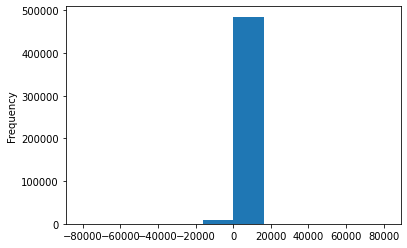

In [15]:
products['Quantity'].plot(kind = 'hist')
plt.show()

In [16]:
# removing quantities less than 0
products = products[products.Quantity > 0]

In [17]:
products.shape

(485117, 9)

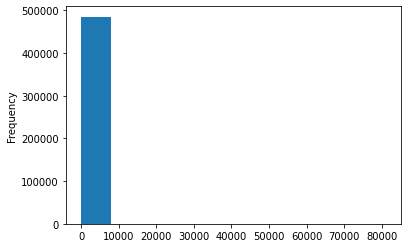

In [18]:
products['Quantity'].plot(kind = 'hist')
plt.show()

In [19]:
products['Quantity'].quantile(0.99)

100.0

In [20]:
sum(products['Quantity']>100)

3559

In [21]:
# Removing top 1% and keeping 99% of the data
products = products[products['Quantity']<=100]

In [22]:
products.shape

(481558, 9)

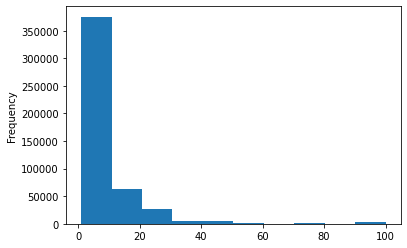

In [23]:
products['Quantity'].plot(kind = 'hist')
plt.show()

In [24]:
sum(products['Quantity'] > 60)

4964

In [25]:
products = products[products['Quantity'] < 60]

In [26]:
products.shape

(476080, 9)

In [27]:
df.shape

(541909, 9)

In [28]:
products.shape[0] / df.shape[0]

0.8785238850065232

In [29]:
products.describe()

Quantity      UnitPrice     CustomerID
count  476080.000000  476080.000000  345556.000000
mean        6.474857       3.317674   15551.717510
std         8.425976       4.355862    1593.270622
min         1.000000       0.000000   12747.000000
25%         1.000000       1.250000   14194.000000
50%         3.000000       2.100000   15521.000000
75%        10.000000       4.130000   16931.000000
max        59.000000     649.500000   18287.000000

In [30]:
products = products[products['UnitPrice'] > 0]

# Handling missing values

## Description

In [31]:
product_description_count = products.groupby(['productId', 'Description'], sort = False)['InvoiceNo'].count().reset_index()

In [32]:
product_description_count.columns = ['productId', 'Description', 'count']

In [33]:
product_description_count.shape

(4113, 3)

In [34]:
product_description_count = product_description_count.sort_values('count', ascending=False).drop_duplicates('productId')

In [35]:
product_description_count.head()

productId                         Description  count
0       85123A  WHITE HANGING HEART T-LIGHT HOLDER   2066
324     85099B             JUMBO BAG RED RETROSPOT   1762
499      22423            REGENCY CAKESTAND 3 TIER   1690
1608     47566                       PARTY BUNTING   1568
44       20725             LUNCH BAG RED RETROSPOT   1381

In [36]:
product_description_count.shape

(3887, 3)

In [37]:
products.drop('Description', axis = 1, inplace = True)
products = products.merge(product_description_count[['productId', 'Description']], how = 'outer', on='productId')

In [38]:
products.shape

(475078, 9)

In [39]:
products.columns

Index(['InvoiceNo', 'StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice',
       'CustomerID', 'Country', 'productId', 'Description'],
      dtype='object')

In [40]:
products.isnull().sum()

InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     129541
Country             0
productId           0
Description         0
dtype: int64

In [41]:
sum(products[products.Description.isnull()]['CustomerID'].isnull())

0

- For 106 null Description values, CustomerID is also Null
- Droppig the rows for particular Values

In [42]:
products = products[~products.Description.isnull()]

In [43]:
products['Description'] = products['Description'].apply(lambda x:x.strip())

## Missing CustomerID

In [44]:
# Handling missing CustomerID using InvoiceNo.
# As single Invoice will belong to single customerID
invoice_customer_count = products.groupby(['InvoiceNo', 'CustomerID'], sort = False)['productId'].count().reset_index()

In [45]:
invoice_customer_count.columns = ['InvoiceNo', 'CustomerID', 'count']

In [46]:
invoice_customer_count.shape

(15870, 3)

In [47]:
invoice_customer_count = invoice_customer_count.sort_values('count', ascending=False).drop_duplicates('InvoiceNo')

In [48]:
invoice_customer_count.shape

(15870, 3)

- There are no duplicates or repeating Invoices

In [49]:
# distribution products sold based on presence or absence of customer
products['custIdPresent'] = pd.notna(products['CustomerID'])

In [50]:
products['custIdPresent'].value_counts(normalize = True)

True     0.727327
False    0.272673
Name: custIdPresent, dtype: float64

In [51]:
products.groupby('custIdPresent')['Quantity'].value_counts()

custIdPresent  Quantity
False          1           73576
               2           23539
               3           10017
               4            6105
               5            3543
                           ...  
True           49              3
               51              3
               57              2
               55              1
               59              1
Name: Quantity, Length: 118, dtype: int64

- When the product is returned, the Quantity is marked as negative
- Cannot remove the Null CustomerID column

- Since we are dealing with Product Segmentation, Null CutomerID won't make any difference

# RFM Analysis and Product Segmentation

## Recency

In [52]:
# currentdate is latest invoiceDate in data
products['date'] = products['InvoiceDate'].dt.date
currentDate = products['date'].max()

In [53]:
currentDate

datetime.date(2011, 12, 9)

In [54]:
# get max purchase date of the product
product_max_date = products.groupby('productId').date.max().reset_index()
product_max_date.columns = ['productId', 'maxPurchaseDate']

# Recency is an indication of how recent the product is sold
product_max_date['recency'] = (currentDate - product_max_date['maxPurchaseDate']) / np.timedelta64(1, 'D')

In [55]:
product_max_date.shape

(3887, 3)

In [56]:
products = products.merge(product_max_date, on = 'productId')

In [57]:
products.columns

Index(['InvoiceNo', 'StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice',
       'CustomerID', 'Country', 'productId', 'Description', 'custIdPresent',
       'date', 'maxPurchaseDate', 'recency'],
      dtype='object')

1
2
3
4
5
6
7
8
9
10
11
12
13
14


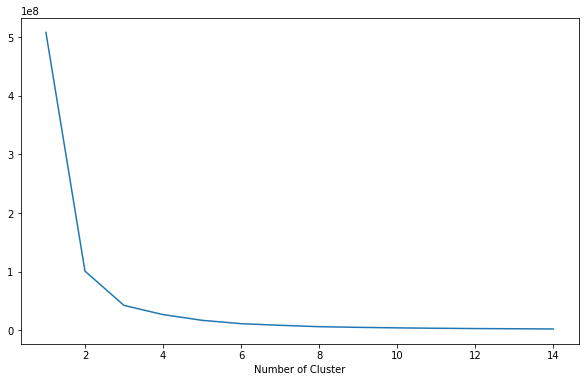

In [58]:
# Applying K-Means for Recency Cluster
from sklearn.cluster import KMeans
sumSquaredError = {}
recency = products[['recency']]

for k in range(1, 15):
    print(k)
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    sumSquaredError[k]=kmeans.inertia_

plt.figure(figsize = (10,6))
plt.plot(list(sumSquaredError.keys()), list(sumSquaredError.values()))
plt.xlabel('Number of Cluster')
plt.show()

In [59]:
recency = products[['recency']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(recency)
products['recencyCluster'] = kmeans.predict(recency)

In [60]:
products.groupby('recencyCluster')['recency'].describe()

count        mean        std  ...    50%    75%    max
recencyCluster                                   ...                     
0               442361.0    1.122280   2.687939  ...    0.0    1.0   18.0
1                 7015.0  234.803279  44.323571  ...  225.0  256.0  373.0
2                 9004.0  105.761773  28.077185  ...   98.0  126.0  170.0
3                16698.0   36.269314  12.675073  ...   33.0   44.0   68.0

[4 rows x 8 columns]

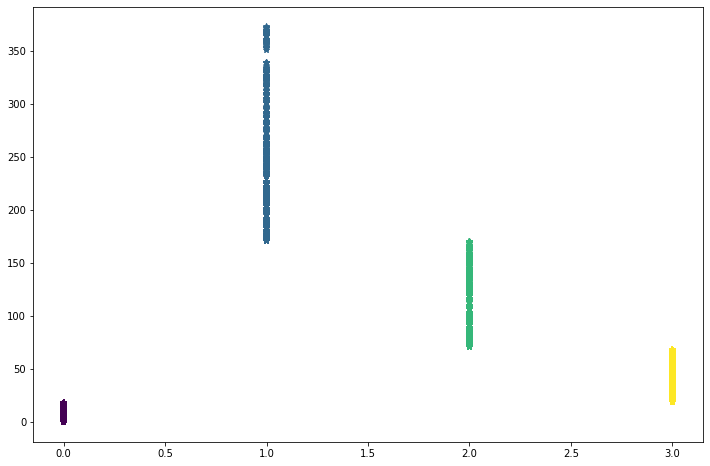

In [61]:
plt.figure(figsize=(12,8))
plt.scatter(products['recencyCluster'], products['recency'], c = products['recencyCluster'], marker = '*')
plt.show()

- **Cluster number is representative of score to that cluster, Recent Article should get higher score**
- Correcting the order of clusters

In [62]:
cluster_df = products.groupby('recencyCluster')['recency'].mean().reset_index()
cluster_df = cluster_df.sort_values('recency', ascending = False).reset_index(drop=True)
cluster_df['new_cluster'] = cluster_df.index
cluster_df.drop('recency', axis = 1, inplace = True)
products = products.merge(cluster_df, on = 'recencyCluster')
products.drop('recencyCluster', axis = 1, inplace = True)
products = products.rename(columns = {'new_cluster' : 'recencyCluster'})
products.head()

InvoiceNo StockCode  Quantity  ... maxPurchaseDate  recency  recencyCluster
0    536365    85123A         6  ...      2011-12-09      0.0               3
1    536373    85123A         6  ...      2011-12-09      0.0               3
2    536375    85123A         6  ...      2011-12-09      0.0               3
3    536394    85123A        32  ...      2011-12-09      0.0               3
4    536396    85123A         6  ...      2011-12-09      0.0               3

[5 rows x 14 columns]

In [63]:
products.groupby('recencyCluster')['recency'].describe()

count        mean        std  ...    50%    75%    max
recencyCluster                                   ...                     
0                 7015.0  234.803279  44.323571  ...  225.0  256.0  373.0
1                 9004.0  105.761773  28.077185  ...   98.0  126.0  170.0
2                16698.0   36.269314  12.675073  ...   33.0   44.0   68.0
3               442361.0    1.122280   2.687939  ...    0.0    1.0   18.0

[4 rows x 8 columns]

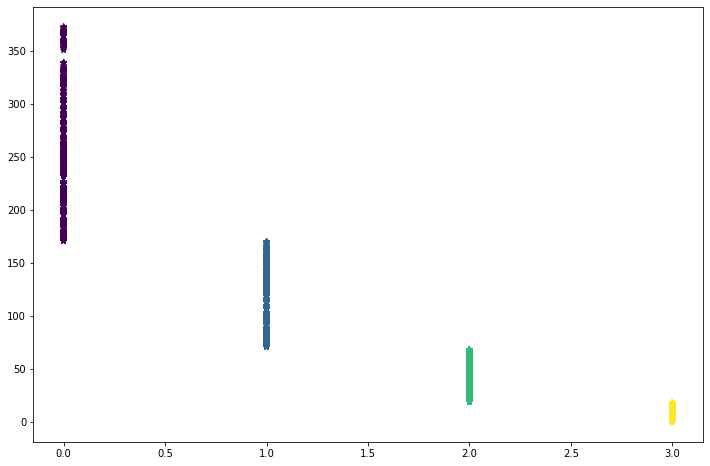

In [64]:
plt.figure(figsize=(12,8))
plt.scatter(products['recencyCluster'], products['recency'], c = products['recencyCluster'], marker = '*')
plt.show()

- The order has been made and the most recent got the highest score

In [65]:
# function for ordering Recency, Frequency and Monetory clusters
def orderClusters(currentCluster, parameter, ascend, data):
    cluster_df = products.groupby(currentCluster)[parameter].mean().reset_index()
    cluster_df = cluster_df.sort_values(parameter, ascending = ascend).reset_index(drop=True)
    cluster_df['new_cluster'] = cluster_df.index
    cluster_df.drop(parameter, axis = 1, inplace = True)
    data = data.merge(cluster_df, on = currentCluster)
    data.drop(currentCluster, axis = 1, inplace = True)
    data = data.rename(columns = {'new_cluster' : currentCluster})
    return data

In [66]:
products = orderClusters('recencyCluster', 'recency', False, products)

## Frequency

In [67]:
frequentProducts = products.groupby('productId')['InvoiceNo'].count().reset_index()
frequentProducts.columns = ['productId', 'frequency']

In [68]:
products = products.merge(frequentProducts, on = 'productId')

1
2
3
4
5
6
7
8
9
10
11
12
13
14


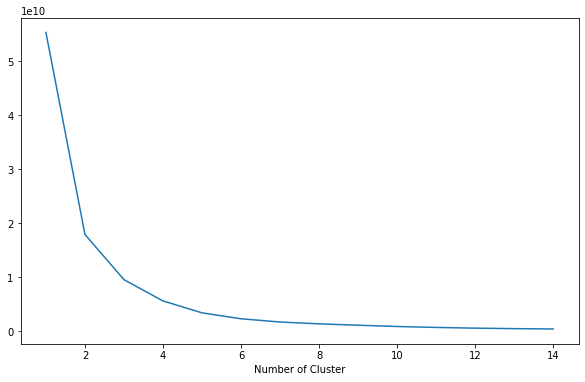

In [69]:
# Applying K-Means for Frequency Cluster
from sklearn.cluster import KMeans
sumSquaredError = {}
frequency = products[['frequency']]

for k in range(1, 15):
    print(k)
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(frequency)
    sumSquaredError[k]=kmeans.inertia_

plt.figure(figsize = (10,6))
plt.plot(list(sumSquaredError.keys()), list(sumSquaredError.values()))
plt.xlabel('Number of Cluster')
plt.show()

In [70]:
frequency = products[['frequency']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(frequency)
products['frequencyCluster'] = kmeans.predict(frequency)

In [71]:
products.groupby('frequencyCluster')['frequency'].describe()

count         mean         std  ...     50%     75%     max
frequencyCluster                                     ...                        
0                 264237.0   153.230096   80.908298  ...   148.0   218.0   306.0
1                  63764.0   925.034000  161.396139  ...   889.0  1069.0  1249.0
2                 137269.0   457.652879  106.688537  ...   437.0   542.0   691.0
3                   9808.0  1672.754690  255.398728  ...  1690.0  1762.0  2075.0

[4 rows x 8 columns]

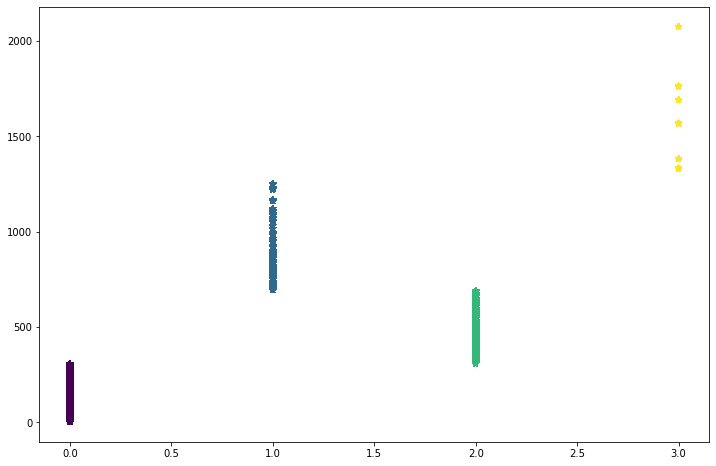

In [72]:
plt.figure(figsize=(12,8))
plt.scatter(products['frequencyCluster'], products['frequency'], c = products['frequencyCluster'], marker = '*')
plt.show()

In [73]:
products = orderClusters('frequencyCluster', 'frequency', True, products)

In [74]:
products.groupby('frequencyCluster')['frequency'].describe()

count         mean         std  ...     50%     75%     max
frequencyCluster                                     ...                        
0                 264237.0   153.230096   80.908298  ...   148.0   218.0   306.0
1                 137269.0   457.652879  106.688537  ...   437.0   542.0   691.0
2                  63764.0   925.034000  161.396139  ...   889.0  1069.0  1249.0
3                   9808.0  1672.754690  255.398728  ...  1690.0  1762.0  2075.0

[4 rows x 8 columns]

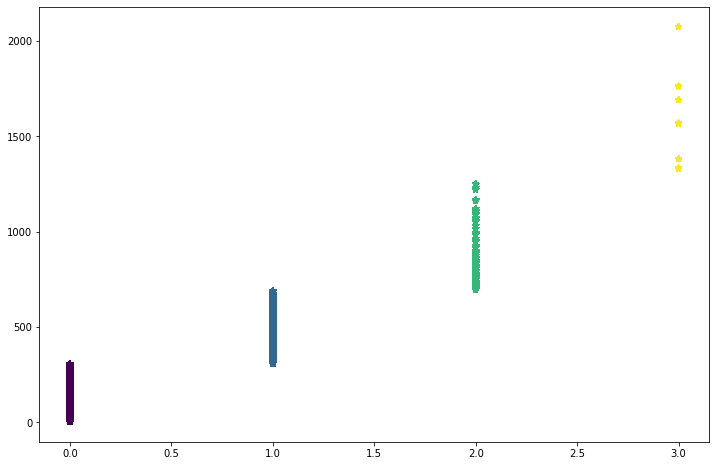

In [75]:
plt.figure(figsize=(12,8))
plt.scatter(products['frequencyCluster'], products['frequency'], c = products['frequencyCluster'], marker = '*')
plt.show()

## Monetary

In [76]:
products['totalPrice'] = products['UnitPrice'] * products['Quantity']

In [77]:
monetaryProducts = products.groupby('productId')['totalPrice'].mean().reset_index()
monetaryProducts.columns = ['productId', 'monetary']
products = products.merge(monetaryProducts, on='productId')

1
2
3
4
5
6
7
8
9
10
11
12
13
14


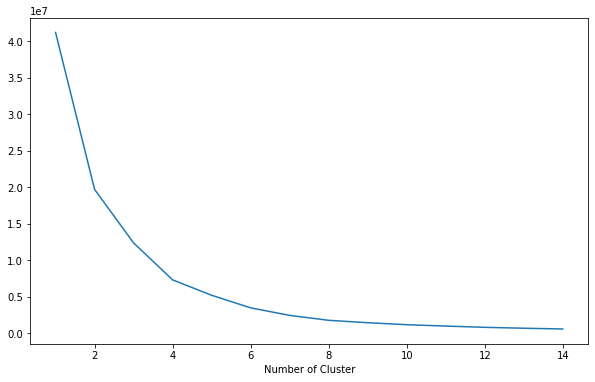

In [78]:
# Applying K-Means for Monetary Cluster
from sklearn.cluster import KMeans
sumSquaredError = {}
monetary = products[['monetary']]

for k in range(1, 15):
    print(k)
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(monetary)
    sumSquaredError[k]=kmeans.inertia_

plt.figure(figsize = (10,6))
plt.plot(list(sumSquaredError.keys()), list(sumSquaredError.values()))
plt.xlabel('Number of Cluster')
plt.show()

In [79]:
monetary = products[['monetary']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(monetary)
products['monetaryCluster'] = kmeans.predict(monetary)

In [80]:
products.groupby('monetaryCluster')['monetary'].describe()

count       mean  ...        75%         max
monetaryCluster                       ...                       
0                188118.0  15.872549  ...  18.053239   22.449512
1                  2917.0  73.175495  ...  68.687562  303.825000
2                 54250.0  29.076849  ...  31.623935   50.421111
3                229793.0   7.144509  ...   9.379531   11.505333

[4 rows x 8 columns]

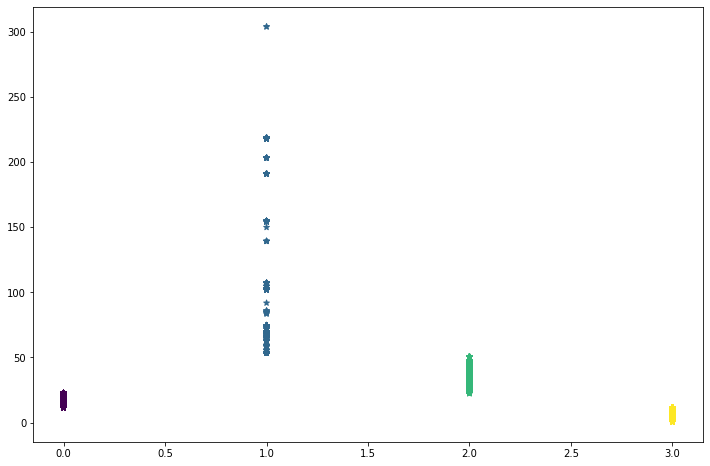

In [81]:
plt.figure(figsize=(12,8))
plt.scatter(products['monetaryCluster'], products['monetary'], c = products['monetaryCluster'], marker = '*')
plt.show()

In [82]:
products = orderClusters('monetaryCluster', 'monetary', True, products)

In [83]:
products.groupby('monetaryCluster')['monetary'].describe()

count       mean  ...        75%         max
monetaryCluster                       ...                       
0                229793.0   7.144509  ...   9.379531   11.505333
1                188118.0  15.872549  ...  18.053239   22.449512
2                 54250.0  29.076849  ...  31.623935   50.421111
3                  2917.0  73.175495  ...  68.687562  303.825000

[4 rows x 8 columns]

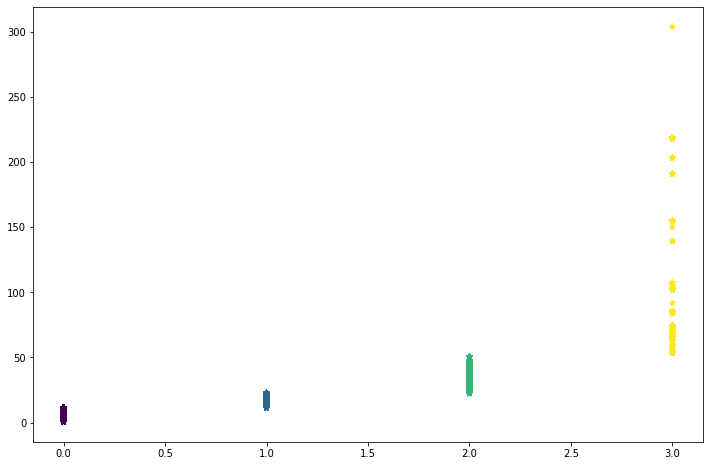

In [84]:
plt.figure(figsize=(12,8))
plt.scatter(products['monetaryCluster'], products['monetary'], c = products['monetaryCluster'], marker = '*')
plt.show()

# Final Score

In [85]:
products['finalScore'] = products['recencyCluster'] + products['frequencyCluster'] + products['monetaryCluster']

In [86]:
products['finalScore'].value_counts(sort=False)

0      4894
1      6355
2     13038
3    153039
4    125589
5     86076
6     66175
7     13247
8      4975
9      1690
Name: finalScore, dtype: int64

In [87]:
productScore = products.drop_duplicates(['productId'])[['productId', 'finalScore']]

In [88]:
productScore = productScore.sort_values('finalScore', ascending=True)

In [89]:
productScore['finalScore'].value_counts(sort = False)

0     350
2     361
4     766
6     100
8       3
1     258
3    1734
5     300
7      14
9       1
Name: finalScore, dtype: int64

## Catgorizing products based on their final score

In [90]:
# best revenue products = final score (6 - 9)
# medium revenue products = final score (3 - 5)
# low revenue products = final score (0 - 2)
products['segment'] = 'low revenue'
products.loc[products['finalScore'] > 2, 'segment'] = 'med revenue'
products.loc[products['finalScore'] > 5, 'segment'] = 'high revenue'

In [91]:
products.drop_duplicates('productId')['segment'].value_counts()

med revenue     2800
low revenue      969
high revenue     118
Name: segment, dtype: int64

**Out of approx. 4000 products 120 products are High Revenue products**

In [92]:
highRevenueProducts = products[products['segment'] == 'high revenue']

In [93]:
highRevenueProducts['Description'].drop_duplicates().tolist()

['WHITE HANGING HEART T-LIGHT HOLDER',
 'ASSORTED COLOUR BIRD ORNAMENT',
 'PARTY BUNTING',
 'WHITE METAL LANTERN',
 'KNITTED UNION FLAG HOT WATER BOTTLE',
 'RED WOOLLY HOTTIE WHITE HEART.',
 'SET 7 BABUSHKA NESTING BOXES',
 'DOORMAT NEW ENGLAND',
 'WOOD 2 DRAWER CABINET WHITE FINISH',
 'WOOD S/3 CABINET ANT WHITE FINISH',
 'HOT WATER BOTTLE TEA AND SYMPATHY',
 'EDWARDIAN PARASOL NATURAL',
 'DOORMAT FANCY FONT HOME SWEET HOME',
 'WOOD BLACK BOARD ANT WHITE FINISH',
 'ENAMEL FLOWER JUG CREAM',
 'ENAMEL BREAD BIN CREAM',
 'DOORMAT FAIRY CAKE',
 'HOT WATER BOTTLE I AM SO POORLY',
 'WHITE SKULL HOT WATER BOTTLE',
 'DOORMAT RED RETROSPOT',
 'DOORMAT HEARTS',
 'ROTATING SILVER ANGELS T-LIGHT HLDR',
 'RECORD FRAME 7" SINGLE SIZE',
 'VINTAGE UNION JACK BUNTING',
 'PAPER BUNTING WHITE LACE',
 'SWEETHEART CAKESTAND 3 TIER',
 'WOODEN ROUNDERS GARDEN SET',
 'RED RETROSPOT CAKE STAND',
 'DOORMAT SPOTTY HOME SWEET HOME',
 '3 HOOK PHOTO SHELF ANTIQUE WHITE',
 'DOORMAT ENGLISH ROSE',
 'DOORMAT UNION FL

# Predicting sales of product

## Modeling using Recency, Frequency and Monetary

In [94]:
highRevenueProducts = products[products['segment'] == 'high revenue']

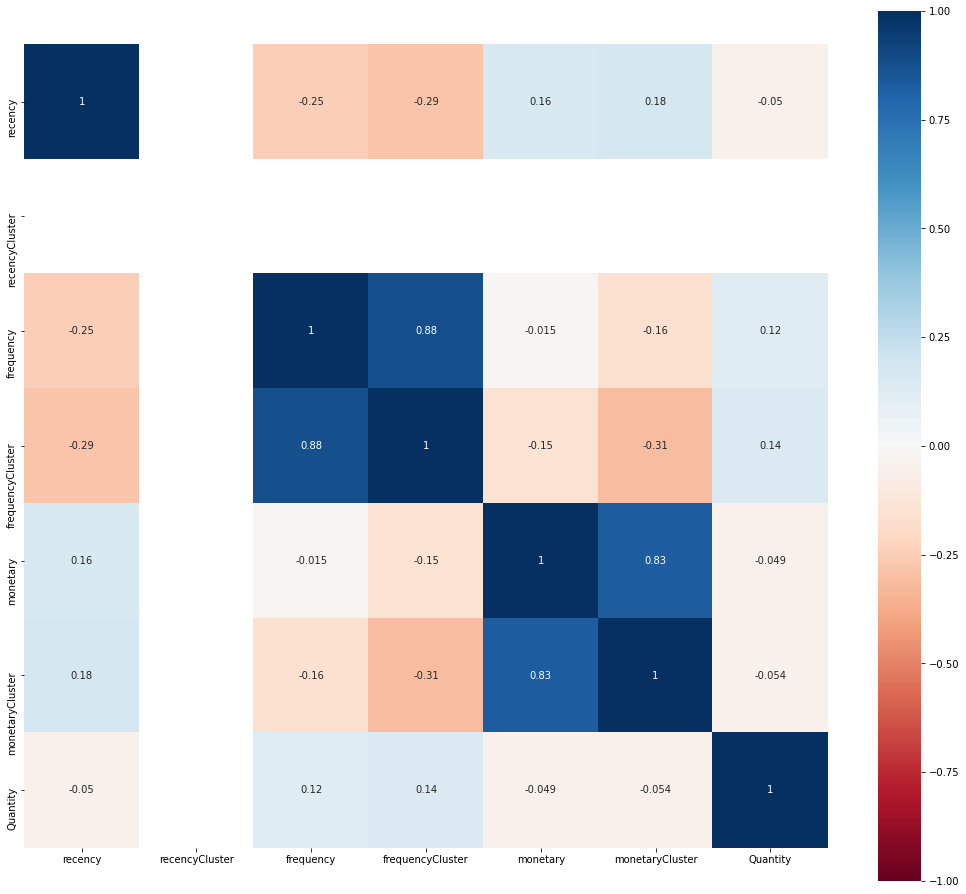

In [95]:
corr_df = highRevenueProducts[['recency', 'recencyCluster', 'frequency', 'frequencyCluster', 
            'monetary', 'monetaryCluster', 'Quantity']]
plt.figure(figsize = (18,16))
sns.heatmap(corr_df.corr(), square=True, annot=True, cmap="RdBu", vmin=-1, vmax=1)
plt.show()

- All features have almost 0 correlation with quanity.
- The result won't be great.

In [96]:
X = highRevenueProducts[['recency', 'recencyCluster', 'frequency',
                         'frequencyCluster', 'monetary', 'monetaryCluster']]
y = highRevenueProducts[['Quantity']]

In [97]:
def create_dummy_variables(X):
    cols = X.columns
    dummy_data = pd.DataFrame()
    for col in cols:
        df_ = pd.get_dummies(X[col], prefix_sep='_', drop_first=True, prefix = col)
        dummy_data = pd.concat([dummy_data, df_], axis = 1)
    return dummy_data

dummy_data = create_dummy_variables(X[['monetaryCluster','frequencyCluster','recencyCluster']])
dummy_data

monetaryCluster_2  ...  frequencyCluster_3
0                       1  ...                   1
1                       1  ...                   1
2                       1  ...                   1
3                       1  ...                   1
4                       1  ...                   1
...                   ...  ...                 ...
245039                  0  ...                   0
245040                  0  ...                   0
245041                  0  ...                   0
245042                  0  ...                   0
245043                  0  ...                   0

[86087 rows x 5 columns]

In [98]:
X.drop(['recencyCluster', 'frequencyCluster', 'monetaryCluster'], axis = 1, inplace = True)
X = pd.concat([X,dummy_data], axis = 1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [100]:
r2_score(y_test, y_pred)

0.08989239292085027

- As expected, R-squared score is very low.
- Since the daily purchase of product is not possible, I will change the Target variable from daily sale to weekly sale 

## Feature Engineering

In [101]:
# adding year_week column
products['yearWeek'] = products['InvoiceDate'].apply(lambda x: 100*x.year + int(x.strftime('%V')))

# introducing day of the week into the data
products['weekDay'] = products['InvoiceDate'].dt.weekday

In [102]:
# Median Price of the product
medianPrice = products.groupby("productId").UnitPrice.median().reset_index()
medianPrice.columns = ['productId', 'medianPrice']
products = products.merge(medianPrice, on = ['productId'])

In [103]:
# Median Quantities sold for that product
medianQuantities = products.groupby("productId").Quantity.median().reset_index()
medianQuantities.columns = ['productId', 'medianQuantities']
products = products.merge(medianQuantities, on = ['productId'])

In [104]:
# Customers for that product
customers = products.groupby("productId").CustomerID.nunique().reset_index()
customers.columns = ['productId', 'customers']
products = products.merge(customers, on = ['productId'])

In [105]:
# Total Sales for the product per week - New target
weeklySales = products.groupby(['yearWeek', 'productId'])['Quantity'].sum().reset_index()
weeklySales.columns = ['yearWeek', 'productId', 'weeklySale']
products = products.merge(weeklySales, on = ['yearWeek', 'productId'])

In [106]:
# Median Sales for the product per day of the week
weekDaySales = products.groupby(['weekDay', 'productId'])['Quantity'].median().reset_index()
weekDaySales.columns = ['weekDay', 'productId', 'medianWeekDaySales']
products = products.merge(weekDaySales, on = ['weekDay', 'productId'])

In [107]:
# Weekly Customers 
customers = products.groupby(['yearWeek', 'productId']).CustomerID.nunique().reset_index()
customers.columns = ['yearWeek', 'productId', 'weeklyCustomers']
products = products.merge(customers, on = ['yearWeek', 'productId'])

In [108]:
# Mean Customers per week
products['meanCustomersPerWeek'] = 1
meanCustomers = products.groupby(['productId', 'yearWeek']).meanCustomersPerWeek.count().reset_index()
meanCustomers = meanCustomers.groupby('productId').meanCustomersPerWeek.mean().reset_index()
products.drop('meanCustomersPerWeek', axis = 1, inplace = True)
products = products.merge(meanCustomers, on = ['productId'])

In [109]:
# Median Customers per week
products['medianCustomersPerWeek'] = 1
medianCustomers = products.groupby(['productId', 'yearWeek']).medianCustomersPerWeek.count().reset_index()
medianCustomers = medianCustomers.groupby('productId').medianCustomersPerWeek.median().reset_index()
products.drop('medianCustomersPerWeek', axis = 1, inplace = True)
products = products.merge(medianCustomers, on = ['productId'])

In [110]:
products.head()

InvoiceNo StockCode  ...  meanCustomersPerWeek medianCustomersPerWeek
0    536365    85123A  ...             39.150943                   38.0
1    536373    85123A  ...             39.150943                   38.0
2    536375    85123A  ...             39.150943                   38.0
3    536394    85123A  ...             39.150943                   38.0
4    536396    85123A  ...             39.150943                   38.0

[5 rows x 31 columns]

## Modeling with engineered features

In [111]:
highRevenueProducts = products[products['segment'] == 'high revenue']

In [112]:
highRevenueProducts.columns

Index(['InvoiceNo', 'StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice',
       'CustomerID', 'Country', 'productId', 'Description', 'custIdPresent',
       'date', 'maxPurchaseDate', 'recency', 'recencyCluster', 'frequency',
       'frequencyCluster', 'totalPrice', 'monetary', 'monetaryCluster',
       'finalScore', 'segment', 'yearWeek', 'weekDay', 'medianPrice',
       'medianQuantities', 'customers', 'weeklySale', 'medianWeekDaySales',
       'weeklyCustomers', 'meanCustomersPerWeek', 'medianCustomersPerWeek'],
      dtype='object')

In [113]:
highRevenueProducts.Quantity.describe()

count    86087.000000
mean         6.665060
std          8.062212
min          1.000000
25%          2.000000
50%          4.000000
75%         10.000000
max         59.000000
Name: Quantity, dtype: float64

In [114]:
highRevenueProducts['yearWeek'].value_counts()

201146    2917
201148    2885
201145    2883
201147    2835
201144    2429
201149    2327
201049    2293
201143    2068
201138    2042
201137    2035
201139    2000
201119    1999
201140    1975
201120    1934
201141    1843
201142    1834
201123    1817
201136    1744
201127    1697
201050    1682
201129    1673
201135    1636
201121    1521
201134    1506
201130    1500
201118    1495
201048    1479
201113    1427
201124    1425
201132    1416
201115    1410
201125    1409
201128    1405
201131    1404
201112    1400
201116    1357
201133    1329
201111    1325
201122    1306
201108    1302
201114    1267
201104    1249
201109    1240
201110    1236
201105    1189
201126    1183
201107    1122
201103    1068
201101    1056
201102    1031
201106     998
201117     874
201051     610
Name: yearWeek, dtype: int64

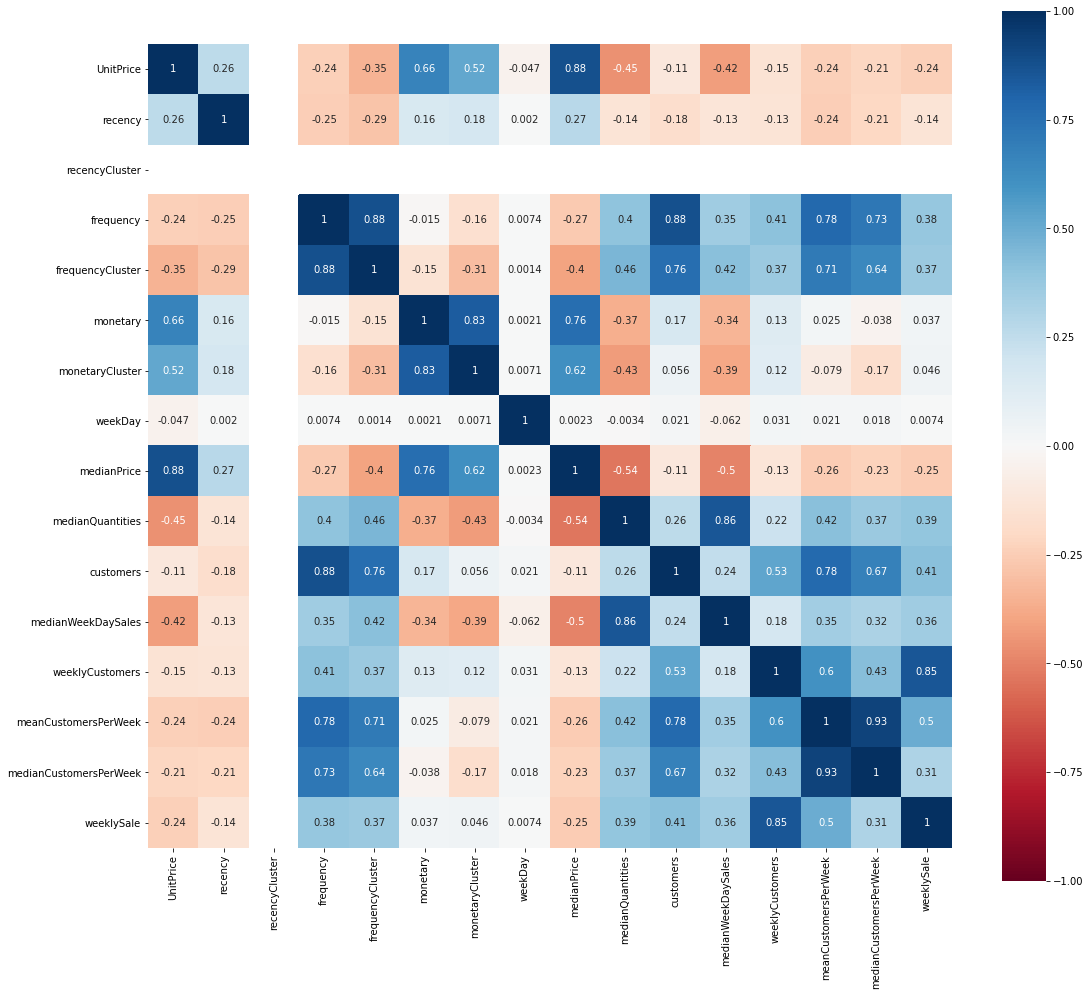

In [115]:
corr_df = highRevenueProducts[['UnitPrice', 'recency', 'recencyCluster', 'frequency',
                         'frequencyCluster', 'monetary', 'monetaryCluster', 
                         'weekDay', 'medianPrice', 'medianQuantities', 
                         'customers', 'medianWeekDaySales','weeklyCustomers', 
                         'meanCustomersPerWeek', 'medianCustomersPerWeek', 'weeklySale']]
plt.figure(figsize = (18,16))
sns.heatmap(corr_df.corr(), square=True, annot=True, cmap="RdBu", vmin=-1, vmax=1)
plt.show()

- Engineered features introduced some correlation 

In [116]:
data = highRevenueProducts[['UnitPrice', 'recency', 'recencyCluster', 'frequency',
                         'frequencyCluster', 'monetary', 'monetaryCluster', 
                         'weekDay', 'medianPrice', 'medianQuantities', 
                         'customers', 'medianWeekDaySales','weeklyCustomers', 
                         'meanCustomersPerWeek', 'medianCustomersPerWeek', 'weeklySale']]

data = data.drop_duplicates()
X = data[['UnitPrice', 'recency', 'recencyCluster', 'frequency',
                         'frequencyCluster', 'monetary', 'monetaryCluster', 
                         'weekDay', 'medianPrice', 'medianQuantities', 
                         'customers', 'medianWeekDaySales','weeklyCustomers', 
                         'meanCustomersPerWeek', 'medianCustomersPerWeek']]
y = data[['weeklySale']]

dummy_data = create_dummy_variables(X[['monetaryCluster','frequencyCluster','recencyCluster', 'weekDay']])
print(dummy_data.head())

X.drop(['recencyCluster', 'frequencyCluster', 'monetaryCluster', 'weekDay'], axis = 1, inplace = True)

X = pd.concat([X,dummy_data], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('R-squared score {}'.format(r2_score(y_test, y_pred)))

    monetaryCluster_2  monetaryCluster_3  ...  weekDay_4  weekDay_6
0                   1                  0  ...          0          0
5                   1                  0  ...          0          0
10                  1                  0  ...          0          0
14                  1                  0  ...          0          0
16                  1                  0  ...          0          0

[5 rows x 10 columns]


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


R-squared score 0.9388217406259599


In [117]:
data.shape

(37931, 16)

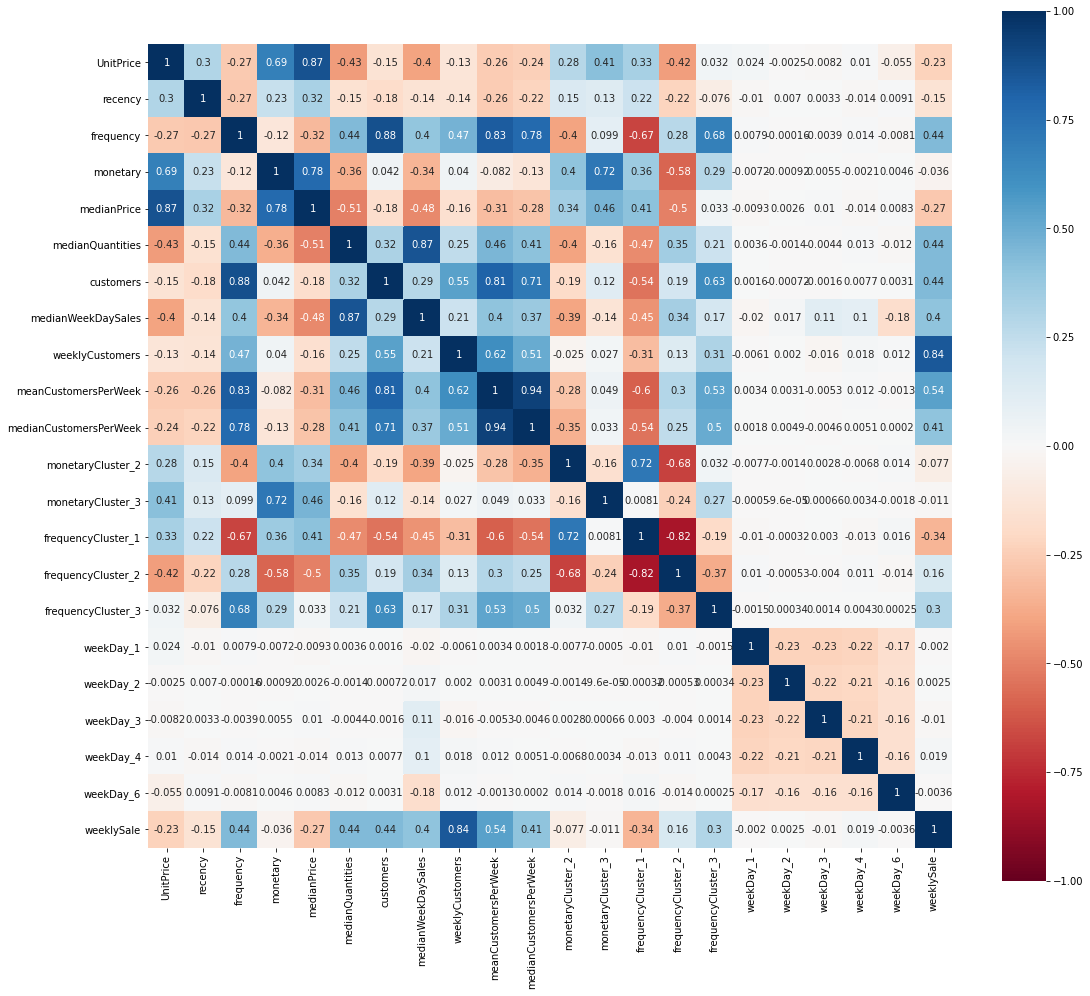

In [118]:
corr_df = pd.concat([X,y], axis= 1)
plt.figure(figsize = (18,16))
sns.heatmap(corr_df.corr(), square=True, annot=True, cmap="RdBu", vmin=-1, vmax=1)
plt.show()

- As expected, **weeklyCustomers** feature helped model to learn about the data.
- While working for future predictions, weeklyCustomers won't be available. Therefore removing **weeklyCustomers** column.
- Since the UnitPrice is volatile, for future predictions, I will be using **medianPrice**

## Removing **weeklyCustomer** Column

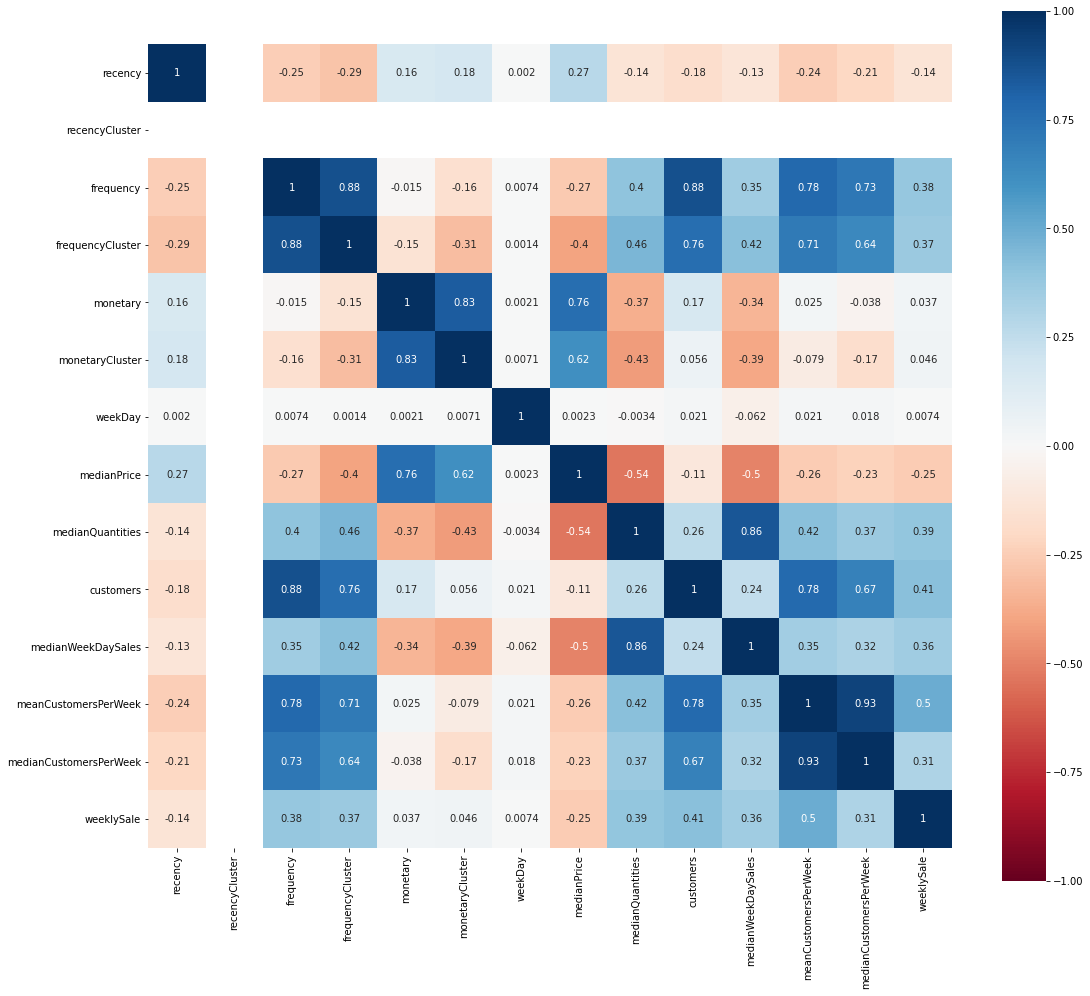

In [119]:
corr_df = highRevenueProducts[['recency', 'recencyCluster', 'frequency',
                         'frequencyCluster', 'monetary', 'monetaryCluster', 
                         'weekDay', 'medianPrice', 'medianQuantities', 
                         'customers', 'medianWeekDaySales', 'meanCustomersPerWeek', 'medianCustomersPerWeek', 'weeklySale']]
plt.figure(figsize = (18,16))
sns.heatmap(corr_df.corr(), square=True, annot=True, cmap="RdBu", vmin=-1, vmax=1)
plt.show()

In [120]:
data = highRevenueProducts[['UnitPrice', 'recency', 'recencyCluster', 'frequency',
                         'frequencyCluster', 'monetary', 'monetaryCluster', 
                         'weekDay', 'medianPrice', 'medianQuantities', 
                         'customers', 'medianWeekDaySales', 
                         'meanCustomersPerWeek', 'medianCustomersPerWeek', 'weeklySale']]

data = data.drop_duplicates()
X = data[['UnitPrice', 'recency', 'recencyCluster', 'frequency',
                         'frequencyCluster', 'monetary', 'monetaryCluster', 
                         'weekDay', 'medianPrice', 'medianQuantities', 
                         'customers', 'medianWeekDaySales', 
                         'meanCustomersPerWeek', 'medianCustomersPerWeek']]
y = data[['weeklySale']]

dummy_data = create_dummy_variables(X[['monetaryCluster','frequencyCluster','recencyCluster', 'weekDay']])
print(dummy_data.head())

X.drop(['recencyCluster', 'frequencyCluster', 'monetaryCluster', 'weekDay'], axis = 1, inplace = True)

X = pd.concat([X,dummy_data], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('R-squared score {}'.format(r2_score(y_test, y_pred)))

    monetaryCluster_2  monetaryCluster_3  ...  weekDay_4  weekDay_6
0                   1                  0  ...          0          0
5                   1                  0  ...          0          0
10                  1                  0  ...          0          0
14                  1                  0  ...          0          0
16                  1                  0  ...          0          0

[5 rows x 10 columns]


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


R-squared score 0.4313527979095789


- Removing weeklyCustomers, UnitPrice



In [121]:
data = highRevenueProducts[['recency', 'recencyCluster', 'frequency',
                         'frequencyCluster', 'monetary', 'monetaryCluster', 
                         'weekDay', 'medianPrice', 'medianQuantities', 
                         'customers', 'medianWeekDaySales',
                         'meanCustomersPerWeek', 'medianCustomersPerWeek', 'weeklySale']]

data = data.drop_duplicates()
X = data[['recency', 'recencyCluster', 'frequency',
                         'frequencyCluster', 'monetary', 'monetaryCluster', 
                         'weekDay', 'medianPrice', 'medianQuantities', 
                         'customers', 'medianWeekDaySales', 
                         'meanCustomersPerWeek', 'medianCustomersPerWeek']]
y = data[['weeklySale']]

dummy_data = create_dummy_variables(X[['monetaryCluster','frequencyCluster','recencyCluster', 'weekDay']])
print(dummy_data.head())

X.drop(['recencyCluster', 'frequencyCluster', 'monetaryCluster', 'weekDay'], axis = 1, inplace = True)

X = pd.concat([X,dummy_data], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('R-squared score {}'.format(r2_score(y_test, y_pred)))

    monetaryCluster_2  monetaryCluster_3  ...  weekDay_4  weekDay_6
0                   1                  0  ...          0          0
14                  1                  0  ...          0          0
32                  1                  0  ...          1          0
39                  1                  0  ...          0          1
51                  1                  0  ...          0          0

[5 rows x 10 columns]


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


R-squared score 0.42578994987374785


## Changing train_test_split

- Keeping the last week as test data and rest weeks data as training data

In [122]:
products['yearWeek'].unique()

array([201048, 201049, 201050, 201051, 201101, 201102, 201103, 201104,
       201105, 201106, 201107, 201108, 201109, 201110, 201111, 201112,
       201113, 201114, 201115, 201116, 201117, 201118, 201119, 201120,
       201121, 201122, 201123, 201124, 201125, 201126, 201127, 201128,
       201129, 201130, 201131, 201132, 201133, 201134, 201135, 201136,
       201137, 201138, 201139, 201140, 201141, 201142, 201143, 201144,
       201145, 201146, 201147, 201148, 201149])

In [123]:
train_data = products[products['yearWeek'] != 201149]
train_data = train_data[['productId', 'recency', 'recencyCluster', 'frequency',
                         'frequencyCluster', 'monetary', 'monetaryCluster', 
                         'weekDay', 'medianPrice', 'medianQuantities', 
                         'customers', 'medianWeekDaySales','weeklyCustomers', 
                         'meanCustomersPerWeek', 'medianCustomersPerWeek', 'weeklySale']]
train_data = train_data.drop_duplicates()

test_data = products[products['yearWeek'] == 201149]
test_data = test_data[['productId', 'recency', 'recencyCluster', 'frequency',
                         'frequencyCluster', 'monetary', 'monetaryCluster', 
                         'weekDay', 'medianPrice', 'medianQuantities', 
                         'customers', 'medianWeekDaySales','weeklyCustomers', 
                         'meanCustomersPerWeek', 'medianCustomersPerWeek', 'weeklySale']]
test_data = test_data.drop_duplicates()

train_data.shape, test_data.shape

((232971, 16), (6735, 16))

In [124]:
X_train, y_train = train_data.iloc[:,:-1], train_data[['weeklySale']]
X_train.shape

(232971, 15)

In [125]:
y_test = test_data[['weeklySale']]
y_test.shape

(6735, 1)

In [126]:
sum(train_data.groupby('productId')['medianCustomersPerWeek'].nunique())

3884

In [127]:
# Recency, recencyCluster, frequency, frequencyCluster, monetary, monetaryCluster,
# 'medianPrice', 'medianQuantities', 'customers', 'medianWeekDaySales',
# 'meanCustomersPerWeek', 'medianCustomersPerWeek' - single value for each productId
# 'weeklyCustomers' -  multiple values per week per product
# 'weeklyCustomers' - value will be taken from last week

X_test = test_data[['productId', 'weekDay']]
X_test = X_test.merge(X_train[['productId', 'recency', 'recencyCluster', 'frequency',
       'frequencyCluster', 'monetary', 'monetaryCluster', 'weekDay',
       'medianPrice', 'medianQuantities', 'customers', 'medianWeekDaySales',
       'meanCustomersPerWeek', 'medianCustomersPerWeek']], on = ['productId', 'weekDay'], how = 'left')
X_test = X_test.drop_duplicates()
X_test.head()
X_test.shape

(6735, 14)

In [128]:
last_week = products[products['yearWeek'] == 201148]
last_week = last_week[['productId', 'weeklyCustomers']]
last_week = last_week.drop_duplicates()
last_week.shape

(2266, 2)

In [129]:
X_test = X_test.merge(last_week, on = 'productId', how = 'left')
X_test.shape

(6735, 15)

In [130]:
null_index = X_test[X_test['weeklyCustomers'].isnull()].index.tolist()
null_index = null_index + X_test[X_test['recency'].isnull()].index.tolist()
y_test = y_test.drop(y_test.index[null_index])
X_test = X_test.drop(X_test.index[null_index])
X_test.isnull().sum()
for col in ['recencyCluster', 'frequencyCluster', 'monetaryCluster']:
  X_test[col] = X_test[col].astype(int)

In [131]:
X_train = X_train.loc[:, X_train.columns != 'productId']
X_test = X_test.loc[:, X_test.columns != 'productId']

In [132]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((232971, 14), (232971, 1), (6273, 14), (6273, 1))

In [133]:
dummy_data = create_dummy_variables(X_train[['monetaryCluster','frequencyCluster','recencyCluster', 'weekDay']])
print(dummy_data.head())
X_train.drop(['recencyCluster', 'frequencyCluster', 'monetaryCluster', 'weekDay'], axis = 1, inplace = True)
X_train = pd.concat([X_train,dummy_data], axis = 1)

dummy_data = create_dummy_variables(X_test[['monetaryCluster','frequencyCluster','recencyCluster', 'weekDay']])
print(dummy_data.head())
X_test.drop(['recencyCluster', 'frequencyCluster', 'monetaryCluster', 'weekDay'], axis = 1, inplace = True)
X_test = pd.concat([X_test,dummy_data], axis = 1)

X_train.shape, X_test.shape

    monetaryCluster_1  monetaryCluster_2  ...  weekDay_4  weekDay_6
0                   0                  1  ...          0          0
14                  0                  1  ...          0          0
32                  0                  1  ...          1          0
39                  0                  1  ...          0          1
51                  0                  1  ...          0          0

[5 rows x 14 columns]
   monetaryCluster_1  monetaryCluster_2  ...  weekDay_3  weekDay_4
0                  0                  1  ...          0          0
1                  0                  1  ...          1          0
2                  0                  1  ...          0          1
3                  0                  1  ...          0          0
4                  0                  1  ...          0          0

[5 rows x 10 columns]


((232971, 24), (6273, 20))

In [134]:
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
  X_test[col] = 0

In [135]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('R-squared score {}'.format(r2_score(y_test, y_pred)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


R-squared score 0.3984952759413104


## Taking median value of weeklyCustomers

In [136]:
train_data = products[products['yearWeek'] != 201149]
train_data = train_data[['productId', 'recency', 'recencyCluster', 'frequency',
                         'frequencyCluster', 'monetary', 'monetaryCluster', 
                         'weekDay', 'medianPrice', 'medianQuantities', 
                         'customers', 'medianWeekDaySales','weeklyCustomers', 
                         'meanCustomersPerWeek', 'medianCustomersPerWeek', 'weeklySale']]
train_data = train_data.drop_duplicates()

test_data = products[products['yearWeek'] == 201149]
test_data = test_data[['productId', 'recency', 'recencyCluster', 'frequency',
                         'frequencyCluster', 'monetary', 'monetaryCluster', 
                         'weekDay', 'medianPrice', 'medianQuantities', 
                         'customers', 'medianWeekDaySales','weeklyCustomers', 
                         'meanCustomersPerWeek', 'medianCustomersPerWeek', 'weeklySale']]
test_data = test_data.drop_duplicates().reset_index(drop = True)

train_data.shape, test_data.shape

((232971, 16), (6735, 16))

In [137]:
X_train, y_train = train_data.iloc[:,:-1], train_data[['weeklySale']]
X_train.shape

(232971, 15)

In [138]:
y_test = test_data[['weeklySale']]
y_test.shape

(6735, 1)

In [139]:
# Recency, recencyCluster, frequency, frequencyCluster, monetary, monetaryCluster,
# 'medianPrice', 'medianQuantities', 'customers', 'medianWeekDaySales',
# 'meanCustomersPerWeek', 'medianCustomersPerWeek' - single value for each productId
# 'weeklyCustomers' -  multiple values per week per product
# 'weeklyCustomers' - value will be taken from last week

X_test = test_data[['productId', 'weekDay']]
X_test = X_test.merge(X_train[['productId', 'recency', 'recencyCluster', 'frequency',
       'frequencyCluster', 'monetary', 'monetaryCluster', 'weekDay',
       'medianPrice', 'medianQuantities', 'customers', 'medianWeekDaySales',
       'meanCustomersPerWeek', 'medianCustomersPerWeek']], on = ['productId', 'weekDay'], how = 'left')
X_test = X_test.drop_duplicates()
print(X_test.head())
X_test.shape

    productId  weekDay  ...  meanCustomersPerWeek  medianCustomersPerWeek
0      85123A        2  ...             39.150943                    38.0
52     85123A        3  ...             39.150943                    38.0
104    85123A        4  ...             39.150943                    38.0
153    85123A        0  ...             39.150943                    38.0
199    85123A        1  ...             39.150943                    38.0

[5 rows x 14 columns]


(6735, 14)

In [140]:
medWeekCustomer = train_data.groupby('productId')['weeklyCustomers'].median().reset_index()
medWeekCustomer.columns = ['productId', 'medWeekCustomer']
X_test = X_test.merge(medWeekCustomer, on = 'productId', how = 'left')
X_test = X_test.drop_duplicates()
X_test = X_test.rename(columns = {'medWeekCustomer' : 'weeklyCustomers'})
X_test.head()
X_test.shape

(6735, 15)

In [141]:
null_index = X_test[X_test['recency'].isnull()].index.tolist()
y_test = y_test.drop(y_test.index[null_index])
X_test = X_test.drop(X_test.index[null_index])
print(X_test.isnull().sum())
for col in ['recencyCluster', 'frequencyCluster', 'monetaryCluster']:
  X_test[col] = X_test[col].astype(int)

productId                 0
weekDay                   0
recency                   0
recencyCluster            0
frequency                 0
frequencyCluster          0
monetary                  0
monetaryCluster           0
medianPrice               0
medianQuantities          0
customers                 0
medianWeekDaySales        0
meanCustomersPerWeek      0
medianCustomersPerWeek    0
weeklyCustomers           0
dtype: int64


In [142]:
X_train = X_train.loc[:, X_train.columns != 'productId']
X_test = X_test.loc[:, X_test.columns != 'productId']

In [143]:
dummy_data = create_dummy_variables(X_train[['monetaryCluster','frequencyCluster','recencyCluster', 'weekDay']])
print(dummy_data.head())
X_train.drop(['recencyCluster', 'frequencyCluster', 'monetaryCluster', 'weekDay'], axis = 1, inplace = True)
X_train = pd.concat([X_train,dummy_data], axis = 1)

dummy_data = create_dummy_variables(X_test[['monetaryCluster','frequencyCluster','recencyCluster', 'weekDay']])
print(dummy_data.head())
X_test.drop(['recencyCluster', 'frequencyCluster', 'monetaryCluster', 'weekDay'], axis = 1, inplace = True)
X_test = pd.concat([X_test,dummy_data], axis = 1)

X_train.shape, X_test.shape

    monetaryCluster_1  monetaryCluster_2  ...  weekDay_4  weekDay_6
0                   0                  1  ...          0          0
14                  0                  1  ...          0          0
32                  0                  1  ...          1          0
39                  0                  1  ...          0          1
51                  0                  1  ...          0          0

[5 rows x 14 columns]
   monetaryCluster_1  monetaryCluster_2  ...  weekDay_3  weekDay_4
0                  0                  1  ...          0          0
1                  0                  1  ...          1          0
2                  0                  1  ...          0          1
3                  0                  1  ...          0          0
4                  0                  1  ...          0          0

[5 rows x 10 columns]


((232971, 24), (6667, 20))

In [144]:
set(X_test.columns) - set(X_train.columns)

set()

In [145]:
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
  X_test[col] = 0

In [146]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [147]:
y_pred = rf.predict(X_test)

print('R-squared score {}'.format(r2_score(y_test, y_pred)))

R-squared score 0.4075237886199279


# Time Series and Pattern Recognition

## EDA

In [148]:
products.columns

Index(['InvoiceNo', 'StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice',
       'CustomerID', 'Country', 'productId', 'Description', 'custIdPresent',
       'date', 'maxPurchaseDate', 'recency', 'recencyCluster', 'frequency',
       'frequencyCluster', 'totalPrice', 'monetary', 'monetaryCluster',
       'finalScore', 'segment', 'yearWeek', 'weekDay', 'medianPrice',
       'medianQuantities', 'customers', 'weeklySale', 'medianWeekDaySales',
       'weeklyCustomers', 'meanCustomersPerWeek', 'medianCustomersPerWeek'],
      dtype='object')

In [149]:
products.head()

InvoiceNo StockCode  ...  meanCustomersPerWeek medianCustomersPerWeek
0    536365    85123A  ...             39.150943                   38.0
1    536373    85123A  ...             39.150943                   38.0
2    536375    85123A  ...             39.150943                   38.0
3    536394    85123A  ...             39.150943                   38.0
4    536396    85123A  ...             39.150943                   38.0

[5 rows x 31 columns]

In [150]:
products['month'] = products['InvoiceDate'].dt.month

In [151]:
products.columns

Index(['InvoiceNo', 'StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice',
       'CustomerID', 'Country', 'productId', 'Description', 'custIdPresent',
       'date', 'maxPurchaseDate', 'recency', 'recencyCluster', 'frequency',
       'frequencyCluster', 'totalPrice', 'monetary', 'monetaryCluster',
       'finalScore', 'segment', 'yearWeek', 'weekDay', 'medianPrice',
       'medianQuantities', 'customers', 'weeklySale', 'medianWeekDaySales',
       'weeklyCustomers', 'meanCustomersPerWeek', 'medianCustomersPerWeek',
       'month'],
      dtype='object')

(array([-100000.,       0.,  100000.,  200000.,  300000.,  400000.,
         500000.]), <a list of 7 Text major ticklabel objects>)

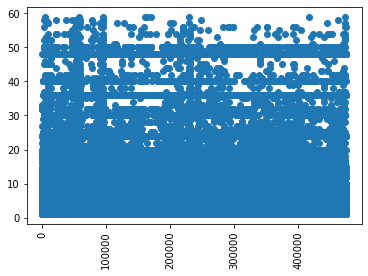

In [152]:
plt.scatter(x=products.index, y=products['Quantity'])
plt.xticks(rotation=90)

In [153]:
products.describe()

Quantity      UnitPrice  ...  medianCustomersPerWeek          month
count  475078.000000  475078.000000  ...           475078.000000  475078.000000
mean        6.471952       3.324671  ...                8.042718       7.584129
std         8.417191       4.357785  ...                7.502580       3.522380
min         1.000000       0.060000  ...                1.000000       1.000000
25%         1.000000       1.250000  ...                3.000000       5.000000
50%         3.000000       2.100000  ...                5.000000       8.000000
75%        10.000000       4.130000  ...               11.000000      11.000000
max        59.000000     649.500000  ...               50.500000      12.000000

[8 rows x 22 columns]

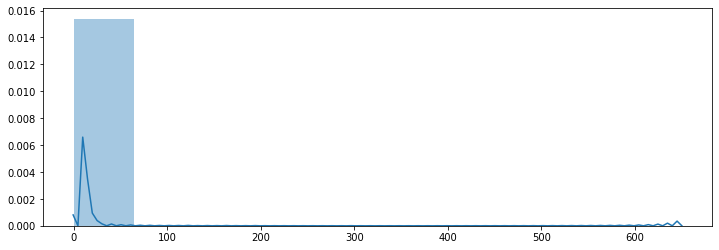

In [154]:
plt.figure(figsize=(12,4))
sns.distplot(products['UnitPrice'].values, kde=True, bins=10)
plt.show()

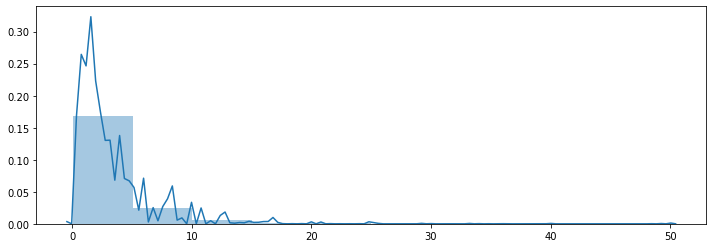

In [155]:
plt.figure(figsize=(12,4))
sns.distplot(products[products['UnitPrice']<50]['UnitPrice'].values, kde=True, bins=10)
plt.show()

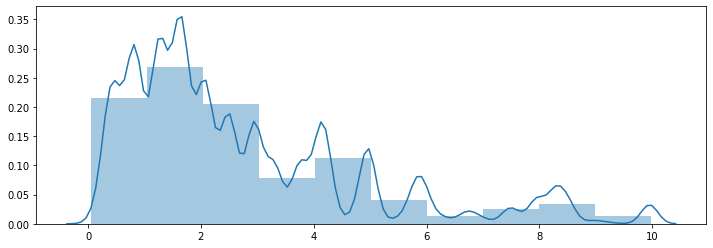

In [156]:
plt.figure(figsize=(12,4))
sns.distplot(products[products['UnitPrice']<10]['UnitPrice'].values, kde=True, bins=10)
plt.show()

- Average UnitPrice of the product lies in the range of 0-3

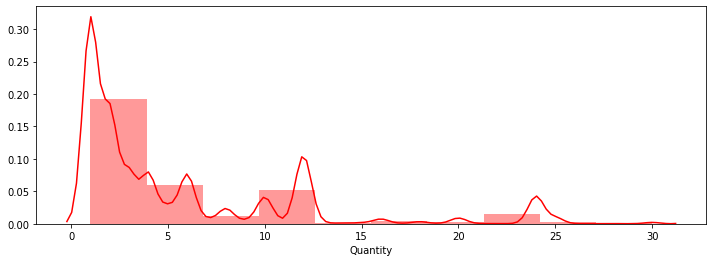

In [157]:
plt.figure(figsize=(12,4))
sns.distplot(products[products['Quantity'] <= 30]['Quantity'], kde=True, bins=10, color='red')
plt.show()

Average Quantity lies in the range of 0-5 or 10-13

## Time Series Distribution

In [158]:
df_q = products[['InvoiceDate','Quantity']].set_index('InvoiceDate', drop = True)
df_q.fillna('-1', inplace=True)
df_q.head()

Quantity
InvoiceDate                  
2010-12-01 08:26:00         6
2010-12-01 09:02:00         6
2010-12-01 09:32:00         6
2010-12-01 10:39:00        32
2010-12-01 10:51:00         6

(54, 1)


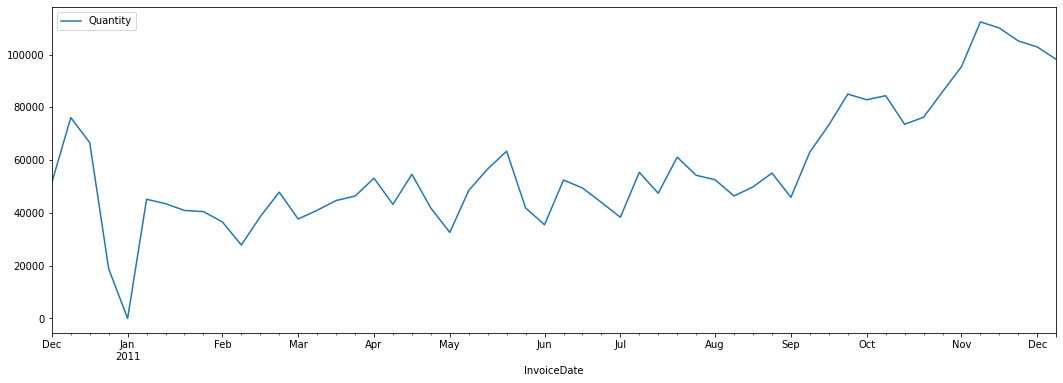

In [159]:
df_resample = df_q.resample('W').sum()
print(df_resample.shape)
df_resample.plot(figsize = (18,6))
plt.show()

- Upward trend
- Sales for first week of January is 0, maybe because of Christmas and store was close

In [160]:
df_cust= products[['InvoiceDate','CustomerID']].set_index('InvoiceDate', drop = True)
df_cust.fillna('-1', inplace=True)
df_cust.head()

CustomerID
InvoiceDate                   
2010-12-01 08:26:00      17850
2010-12-01 09:02:00      17850
2010-12-01 09:32:00      17850
2010-12-01 10:39:00      13408
2010-12-01 10:51:00      17850

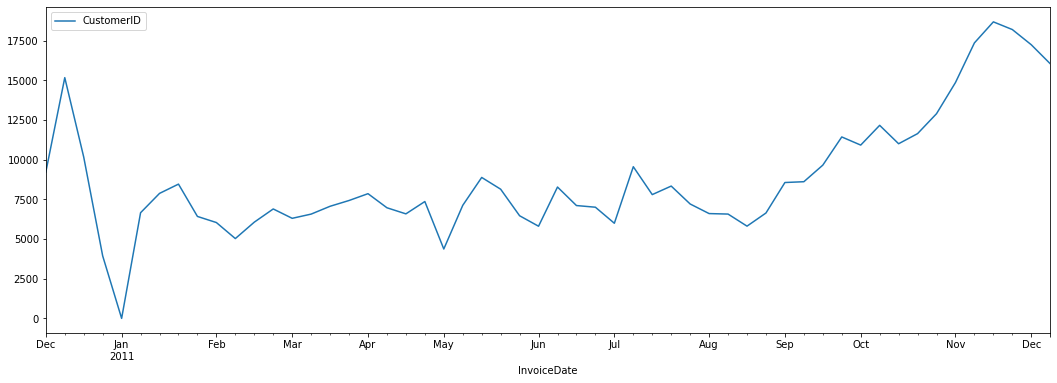

In [161]:
df_weekly = df_cust.resample('W').count()
df_weekly.plot(figsize = (18,6))
plt.show()

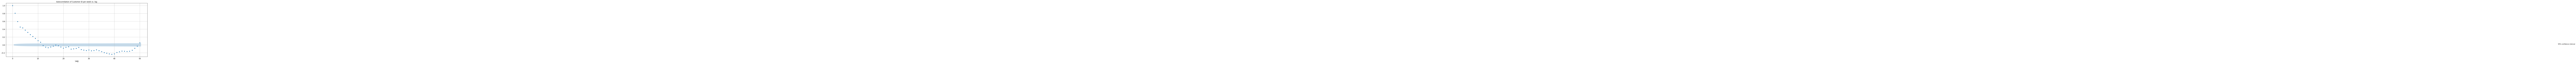

In [162]:
max_lag = 50
fig, ax = plt.subplots(figsize = (18, 7))
acf_plot = plot_acf(x = df_weekly.CustomerID,
                    ax = ax,
                    lags = max_lag,
                    use_vlines = False,
                    alpha = 0.9,
                    title = 'Autocorrelation of Customer ID per week vs. lag')
ax.grid(True)
ax.text(1000, 0.01, '90% confidence interval')
ax.set_xlabel('Lag', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

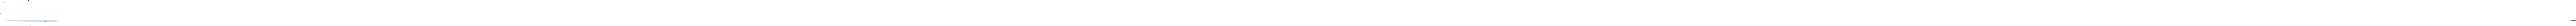

In [163]:
max_lag = 20
fig, ax = plt.subplots(figsize = (18, 7))
acf_plot = plot_acf(x = df_weekly.CustomerID,
                    ax = ax,
                    lags = max_lag,
                    use_vlines = False,
                    alpha = 0.9,
                    title = 'Autocorrelation of Customer count per week vs. lag')
ax.grid(True)
ax.text(1000, 0.01, '90% confidence interval')
ax.set_xlabel('Lag', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

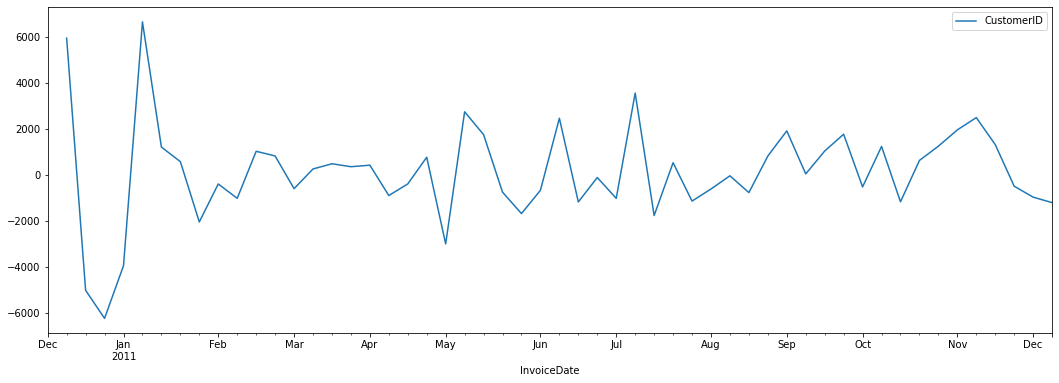

In [164]:
#yt = yt -y(t-1)
df_weekly['CustomerID'] = df_weekly['CustomerID'] - df_weekly['CustomerID'].shift(1)
df_weekly.plot(figsize = (18,6))
plt.show()

In [165]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, col_name, window):

    #Determing rolling statistics
    rolmean = timeseries[col_name].rolling(window=window).mean()
    rolstd = timeseries[col_name].rolling(window=window).std()

    #Plot rolling statistics:
    plt.figure(figsize=(18,6))
    orig = plt.plot(timeseries[col_name], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries[col_name], autolag='AIC')
    print('Test Done')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

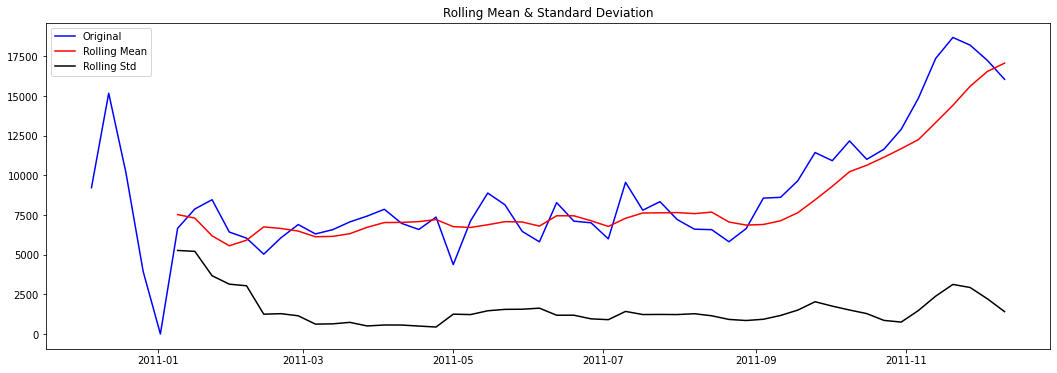

Results of Dickey-Fuller Test:
Test Done
Test Statistic                 -1.697566
p-value                         0.432367
#Lags Used                      0.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


In [166]:
df_weekly = df_cust.resample('W').count()
test_stationarity(df_weekly, 'CustomerID', 6)

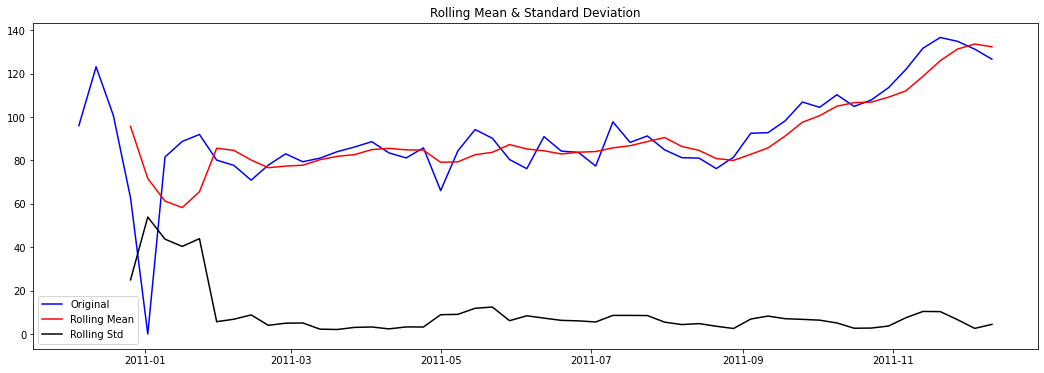

Results of Dickey-Fuller Test:
Test Done
Test Statistic                 -2.933206
p-value                         0.041621
#Lags Used                      0.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


In [167]:
ts_weekly = df_cust.resample('W').count()
ts_weekly = np.sqrt(ts_weekly)
test_stationarity(ts_weekly, 'CustomerID',4)

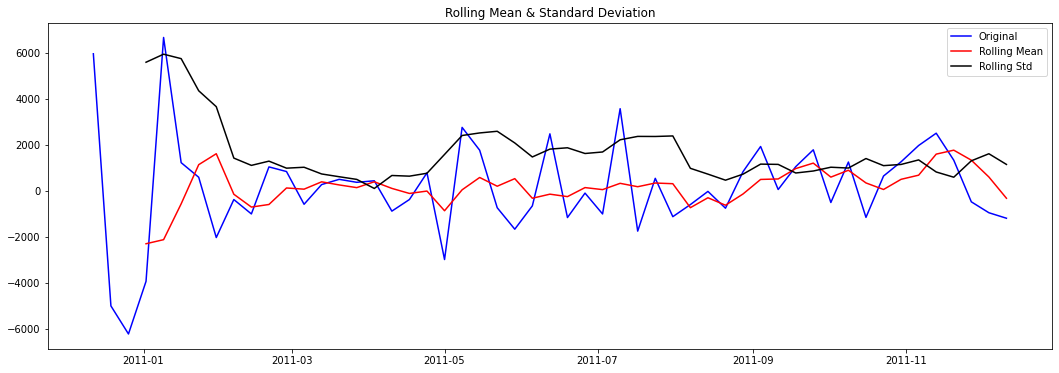

Results of Dickey-Fuller Test:
Test Done
Test Statistic                -7.603421e+00
p-value                        2.356321e-11
#Lags Used                     0.000000e+00
Number of Observations Used    5.200000e+01
Critical Value (1%)           -3.562879e+00
Critical Value (5%)           -2.918973e+00
Critical Value (10%)          -2.597393e+00
dtype: float64


In [168]:
ts_weekly = df_cust.resample('W').count()
ts_weekly['prev_count'] = ts_weekly['CustomerID'] - ts_weekly['CustomerID'].shift(1)
test_stationarity(ts_weekly[1:], 'prev_count',4)

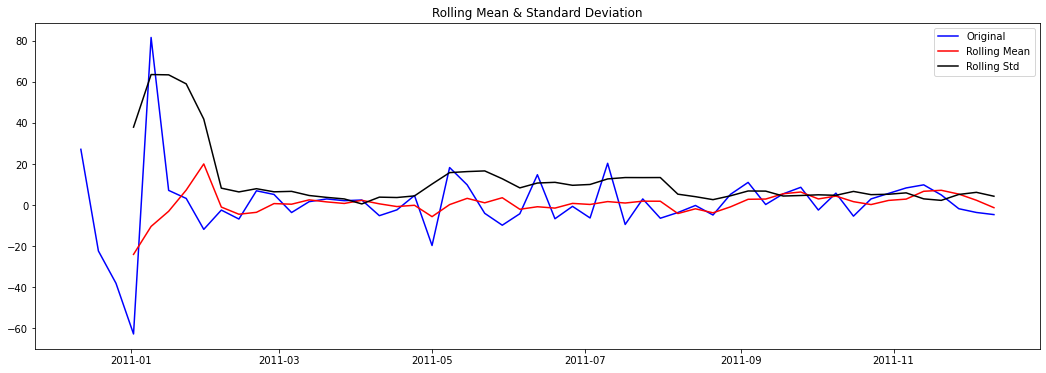

Results of Dickey-Fuller Test:
Test Done
Test Statistic                -8.416158e+00
p-value                        2.041091e-13
#Lags Used                     0.000000e+00
Number of Observations Used    5.200000e+01
Critical Value (1%)           -3.562879e+00
Critical Value (5%)           -2.918973e+00
Critical Value (10%)          -2.597393e+00
dtype: float64


In [169]:
ts_weekly = df_cust.resample('W').count()
ts_weekly = np.sqrt(ts_weekly)
ts_weekly['prev_count'] = ts_weekly['CustomerID'] - ts_weekly['CustomerID'].shift(1)
test_stationarity(ts_weekly[1:], 'prev_count',4)


## Time Series using **fbprophet**

### Weekly

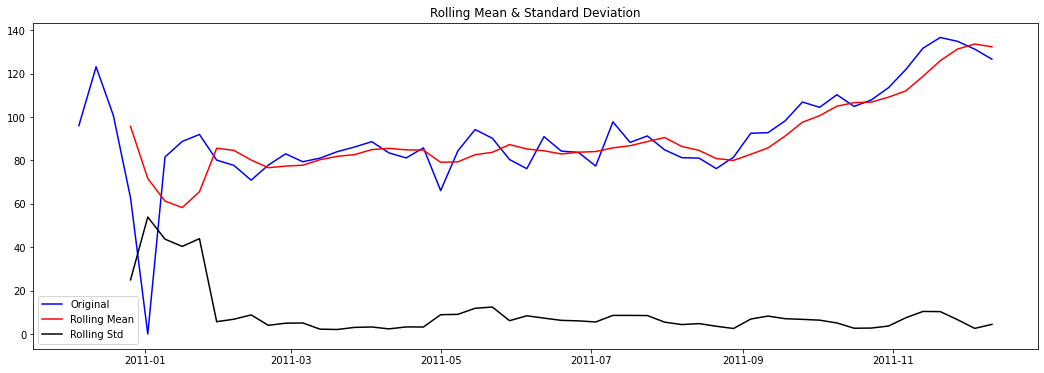

Results of Dickey-Fuller Test:
Test Done
Test Statistic                 -2.933206
p-value                         0.041621
#Lags Used                      0.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


In [170]:
ts_weekly = df_cust.resample('W').count()
ts_weekly = np.sqrt(ts_weekly)
ts_weekly['prev_count'] = ts_weekly['CustomerID'] - ts_weekly['CustomerID'].shift(1)
test_stationarity(ts_weekly, 'CustomerID',4)
# test_stationarity(ts_weekly[1:], 'prev_count')
ts_weekly = ts_weekly.reset_index()

In [171]:
ts = ts_weekly[['InvoiceDate', 'CustomerID']]
ts.columns = ['ds', 'y']
ts.head()

ds           y
0 2010-12-05   96.026038
1 2010-12-12  123.166554
2 2010-12-19  100.816665
3 2010-12-26   62.753486
4 2011-01-02    0.000000

In [172]:
from fbprophet import Prophet
ts_model_w = Prophet()
ts_model_w.fit(ts)
future = ts_model_w.make_future_dataframe(periods=4, freq = 'W')
prediction = ts_model_w.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


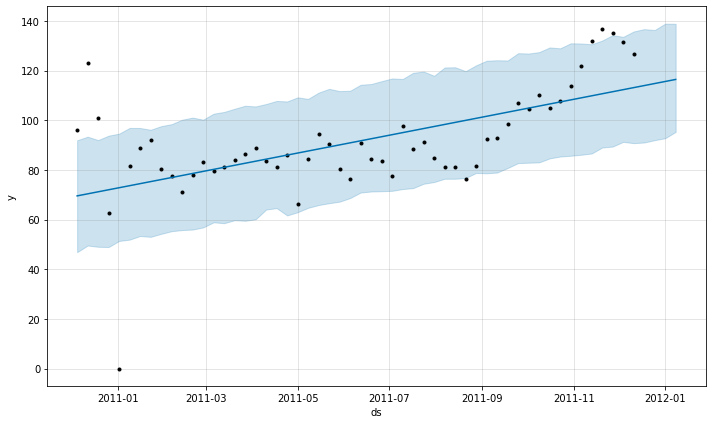

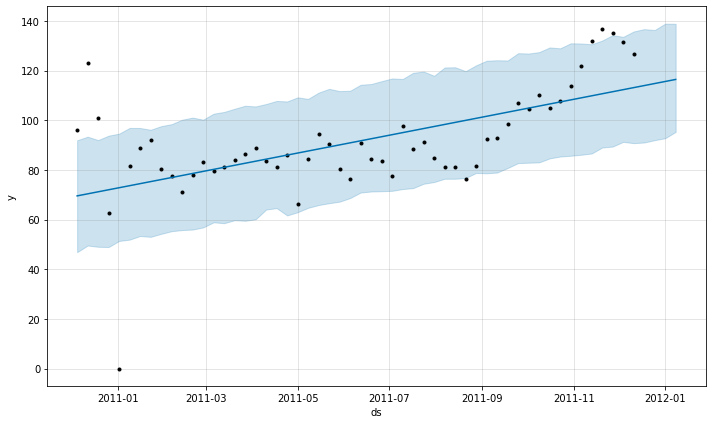

In [173]:
ts_model_w.plot(prediction)

In [174]:
christmas = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2010-12-24',
       '2010-12-25', '2010-12-26', '2010-12-27', '2010-12-28',
       '2010-12-29', '2010-12-30', '2010-12-31', '2011-01-01',
       '2011-01-02', '2011-01-03']),
  'lower_window': 0,
  'upper_window': 1,
})

ts_weekly = df_cust.resample('W').count()
ts_weekly['prev_count'] = ts_weekly['CustomerID'] - ts_weekly['CustomerID'].shift(1)
ts_weekly = ts_weekly.reset_index()

ts = ts_weekly[['InvoiceDate', 'prev_count']][1:]
ts.columns = ['ds', 'y']
ts.head()
ts_model_w = Prophet(holidays = christmas)
ts_model_w.fit(ts)
future = ts_model_w.make_future_dataframe(periods=10, freq = 'W')
prediction = ts_model_w.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


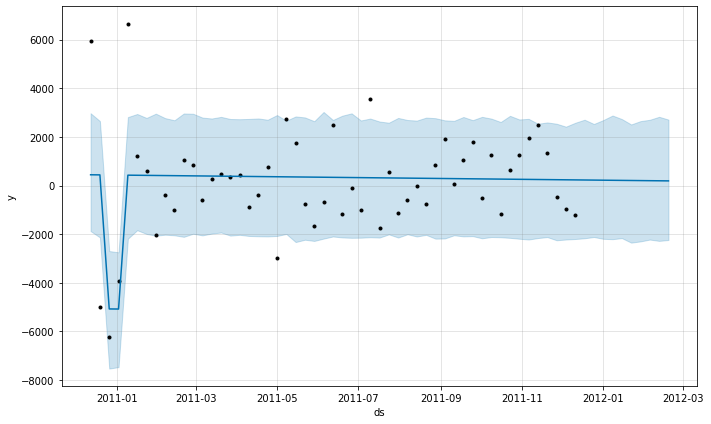

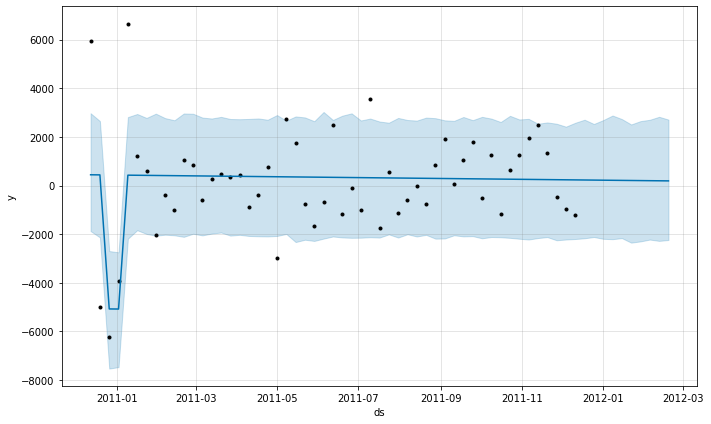

In [175]:
ts_model_w.plot(prediction)

In [176]:
prediction[['ds', 'yhat']].tail(10)

ds        yhat
53 2011-12-18  228.304502
54 2011-12-25  224.255345
55 2012-01-01  220.206188
56 2012-01-08  216.157031
57 2012-01-15  212.107873
58 2012-01-22  208.058716
59 2012-01-29  204.009559
60 2012-02-05  199.960402
61 2012-02-12  195.911245
62 2012-02-19  191.862088

In [177]:
ts_weekly.tail(7)

InvoiceDate  CustomerID  prev_count
47  2011-10-30       12898      1256.0
48  2011-11-06       14862      1964.0
49  2011-11-13       17360      2498.0
50  2011-11-20       18685      1325.0
51  2011-11-27       18201      -484.0
52  2011-12-04       17243      -958.0
53  2011-12-11       16046     -1197.0

### Daily

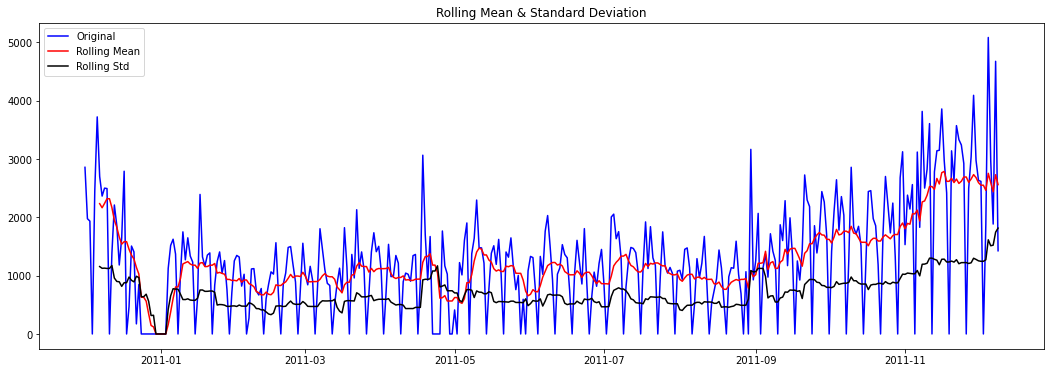

Results of Dickey-Fuller Test:
Test Done
Test Statistic                  -1.811662
p-value                          0.374687
#Lags Used                      16.000000
Number of Observations Used    357.000000
Critical Value (1%)             -3.448801
Critical Value (5%)             -2.869670
Critical Value (10%)            -2.571101
dtype: float64


In [178]:
ts_daily = df_cust.resample('D').count()
ts_daily['prev_count'] = ts_daily['CustomerID'] - ts_daily['CustomerID'].shift(1)
test_stationarity(ts_daily, 'CustomerID',7)
# test_stationarity(ts_weekly[1:], 'prev_count')
ts_daily = ts_daily.reset_index()

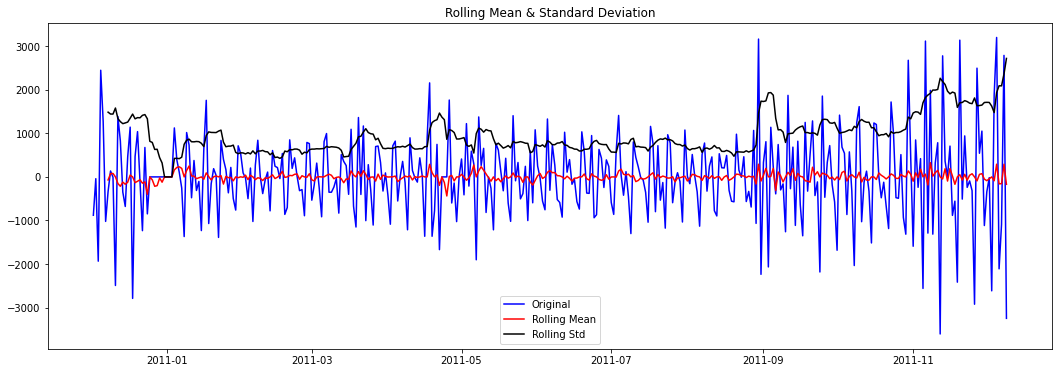

Results of Dickey-Fuller Test:
Test Done
Test Statistic                -6.943605e+00
p-value                        1.010344e-09
#Lags Used                     1.300000e+01
Number of Observations Used    3.590000e+02
Critical Value (1%)           -3.448697e+00
Critical Value (5%)           -2.869625e+00
Critical Value (10%)          -2.571077e+00
dtype: float64


In [179]:
ts_daily = df_cust.resample('D').count()
ts_daily['prev_count'] = ts_daily['CustomerID'] - ts_daily['CustomerID'].shift(1)
#test_stationarity(ts_daily, 'CustomerID')
test_stationarity(ts_daily[1:], 'prev_count',7)
ts_daily = ts_daily.reset_index()

In [180]:
ts = ts_daily[['InvoiceDate', 'prev_count']][1:]
ts.columns = ['ds', 'y']
ts.head()
ts_model_d = Prophet()
ts_model_d.fit(ts)
future = ts_model_d.make_future_dataframe(periods=7, freq = 'D')
prediction = ts_model_d.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


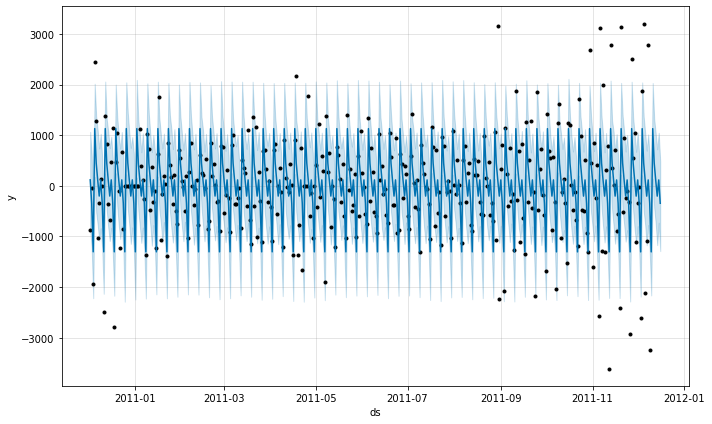

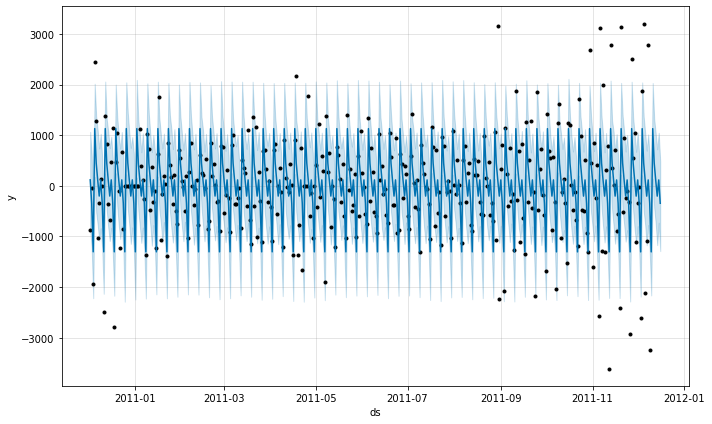

In [181]:
ts_model_d.plot(prediction)

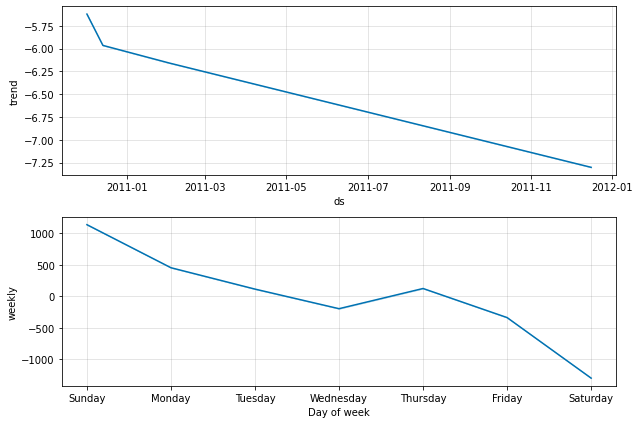

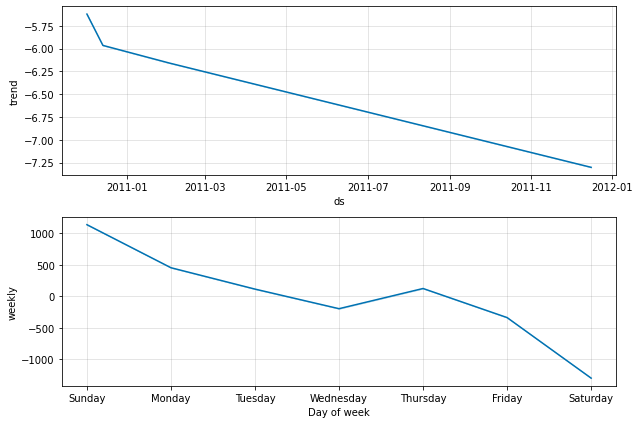

In [182]:
ts_model_d.plot_components(prediction)

In [183]:
christmas = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2010-12-24',
       '2010-12-25', '2010-12-26', '2010-12-27', '2010-12-28',
       '2010-12-29', '2010-12-30', '2010-12-31', '2011-01-01',
       '2011-01-02', '2011-01-03']),
  'lower_window': 0,
  'upper_window': 1,
})
weekly_off = pd.DataFrame({
  'holiday': 'weekly_off',
  'ds': pd.to_datetime(['2010-12-04', '2010-12-11', '2010-12-18', 
                        '2011-01-08', '2011-01-15', '2011-01-22', '2011-01-29', 
                        '2011-02-05', '2011-02-12', '2011-02-19', '2011-02-26', 
                        '2011-03-05', '2011-03-12',
       '2011-03-19', '2011-03-26', '2011-04-02', '2011-04-09',
       '2011-04-16', '2011-04-22', '2011-04-23', '2011-04-24',
       '2011-04-25', '2011-04-29', '2011-04-30', '2011-05-02',
       '2011-05-07', '2011-05-14', '2011-05-21', '2011-05-28',
       '2011-05-30', '2011-06-04', '2011-06-11', '2011-06-18',
       '2011-06-25', '2011-07-02', '2011-07-09', '2011-07-16',
       '2011-07-23', '2011-07-30', '2011-08-06', '2011-08-13',
       '2011-08-20', '2011-08-27', '2011-08-29', '2011-09-03',
       '2011-09-10', '2011-09-17', '2011-09-24', '2011-10-01',
       '2011-10-08', '2011-10-15', '2011-10-22', '2011-10-29',
       '2011-11-05', '2011-11-12', '2011-11-19', '2011-11-26',
       '2011-12-03']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((weekly_off, christmas))

In [184]:
ts = ts_daily[['InvoiceDate', 'prev_count']][1:]
ts.columns = ['ds', 'y']
ts.head()
ts_model_d = Prophet(holidays = holidays)
ts_model_d.fit(ts)
future = ts_model_d.make_future_dataframe(periods=7, freq = 'D')
prediction = ts_model_d.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


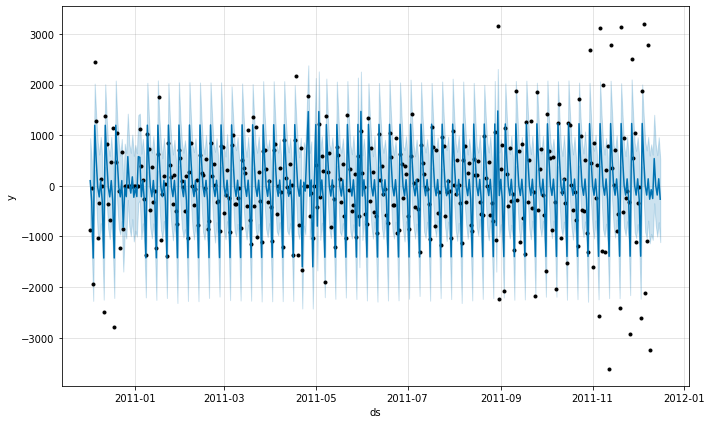

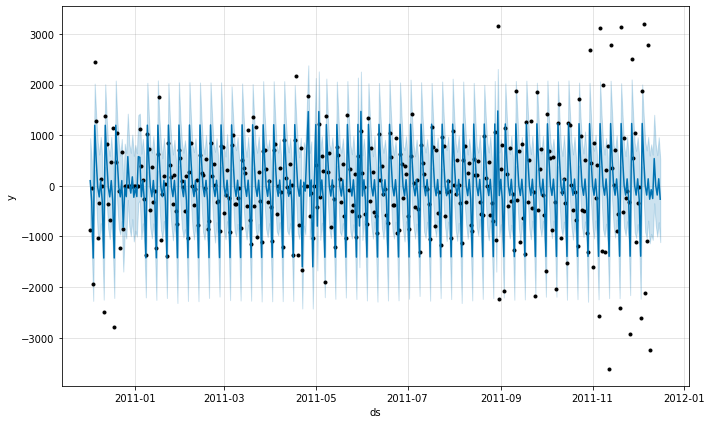

In [185]:
ts_model_d.plot(prediction)

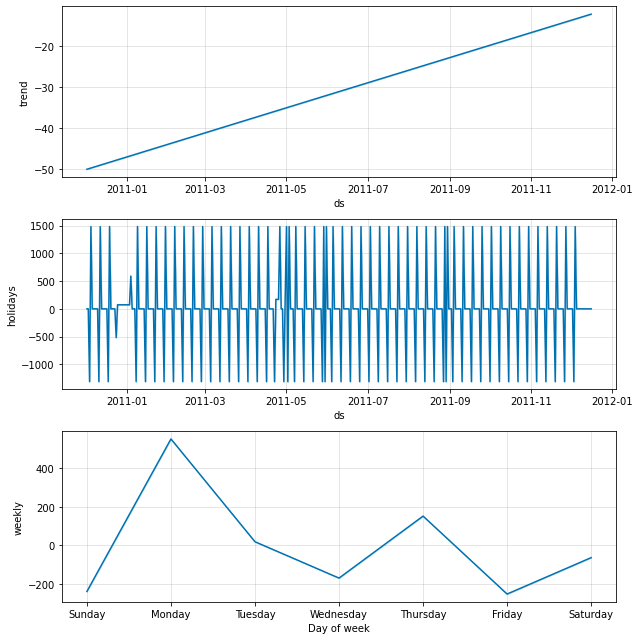

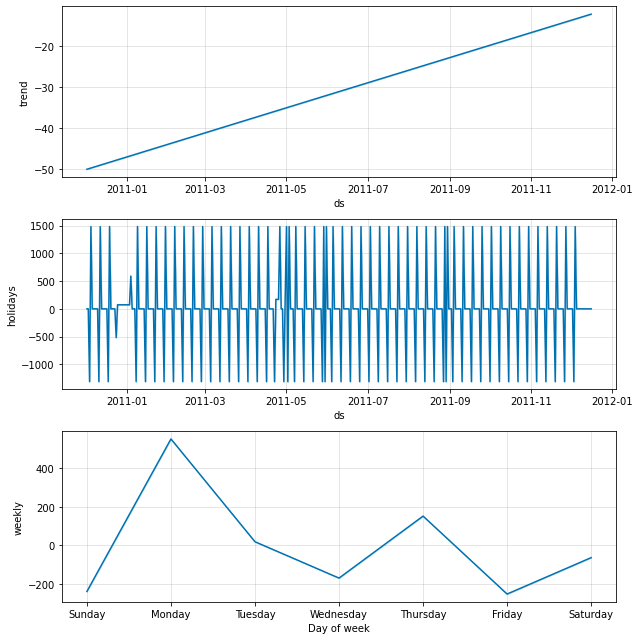

In [186]:
ts_model_d.plot_components(prediction)

In [187]:
prediction[['ds','trend','yhat']].tail(7)

ds      trend        yhat
373 2011-12-10 -12.743240  -75.985074
374 2011-12-11 -12.643536 -250.810309
375 2011-12-12 -12.543831  538.655846
376 2011-12-13 -12.444126    6.588300
377 2011-12-14 -12.344421 -181.377754
378 2011-12-15 -12.244716  139.622570
379 2011-12-16 -12.145011 -263.802460

In [188]:
ts_daily.tail(2)

InvoiceDate  CustomerID  prev_count
372  2011-12-08        4676      2791.0
373  2011-12-09        1427     -3249.0

## Best selling Product

### statsmodel ARIMA

In [189]:
products['count'] = 1

In [190]:
a = products.groupby(['productId'])['count'].sum()

In [191]:
a.sort_values(ascending = False)

productId
85123A    2075
85099B    1762
22423     1690
47566     1568
20725     1381
          ... 
90127A       1
90126C       1
21160        1
90126A       1
35833G       1
Name: count, Length: 3887, dtype: int64

In [192]:
df_p = products[products['productId'] == '85123A']
df_p.head()

InvoiceNo StockCode  Quantity  ... medianCustomersPerWeek  month  count
0    536365    85123A         6  ...                   38.0     12      1
1    536373    85123A         6  ...                   38.0     12      1
2    536375    85123A         6  ...                   38.0     12      1
3    536394    85123A        32  ...                   38.0     12      1
4    536396    85123A         6  ...                   38.0     12      1

[5 rows x 33 columns]

In [193]:
ts_p = df_p[['InvoiceDate', 'count']].set_index('InvoiceDate', drop = True)
ts_p.head()

count
InvoiceDate               
2010-12-01 08:26:00      1
2010-12-01 09:02:00      1
2010-12-01 09:32:00      1
2010-12-01 10:39:00      1
2010-12-01 10:51:00      1

In [194]:
ts_p = ts_p.resample('D').sum()

In [195]:
ts_p.head()

count
InvoiceDate       
2010-12-01      14
2010-12-02      18
2010-12-03       7
2010-12-04       0
2010-12-05      12

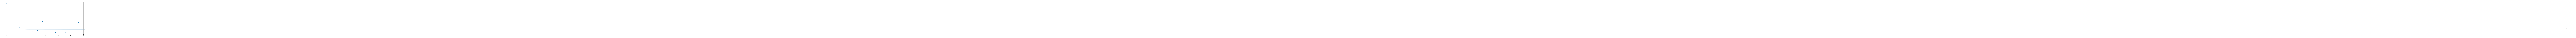

In [196]:
max_lag = 30
fig, ax = plt.subplots(figsize = (18, 7))
acf_plot = plot_acf(x = ts_p['count'],
                    ax = ax,
                    lags = max_lag,
                    use_vlines = False,
                    alpha = 0.9,
                    title = 'Autocorrelation of Customer ID per week vs. lag')
ax.grid(True)
ax.text(1000, 0.01, '90% confidence interval')
ax.set_xlabel('Lag', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

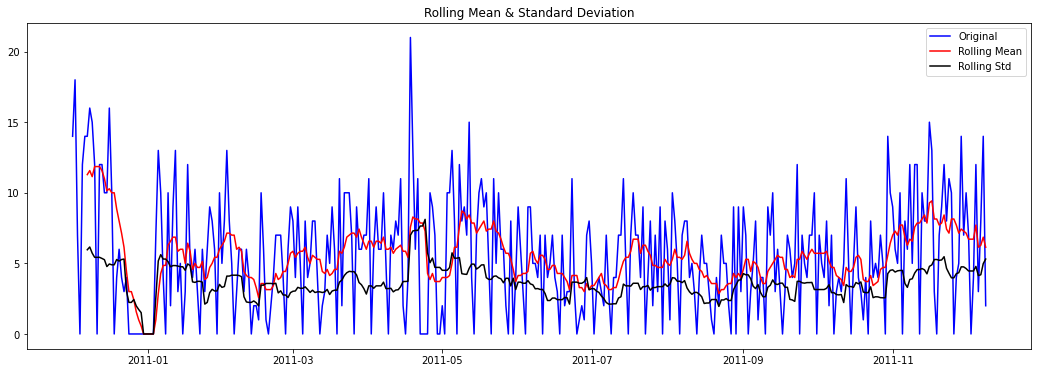

Results of Dickey-Fuller Test:
Test Done
Test Statistic                  -5.470597
p-value                          0.000002
#Lags Used                      15.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


In [197]:
ts_p['prev_count'] = ts_p['count'] - ts_p['count'].shift(1)
test_stationarity(ts_p, 'count', 7)
#test_stationarity(ts_p[1:], 'prev_count')
# ts_p = ts_.reset_index()

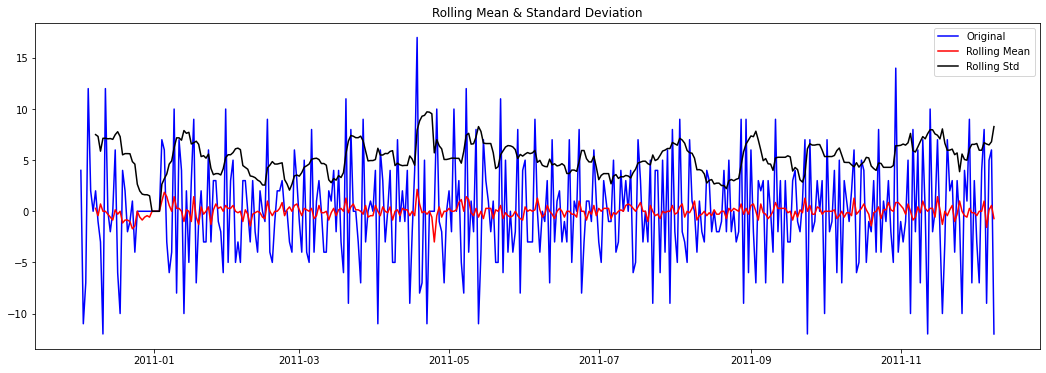

Results of Dickey-Fuller Test:
Test Done
Test Statistic                -7.599128e+00
p-value                        2.415500e-11
#Lags Used                     1.200000e+01
Number of Observations Used    3.600000e+02
Critical Value (1%)           -3.448646e+00
Critical Value (5%)           -2.869602e+00
Critical Value (10%)          -2.571065e+00
dtype: float64


In [198]:
test_stationarity(ts_p[1:], 'prev_count', 7)
# ts_p = ts_.reset_index()

In [199]:
ts_p_prev = ts_p[1:]['prev_count']

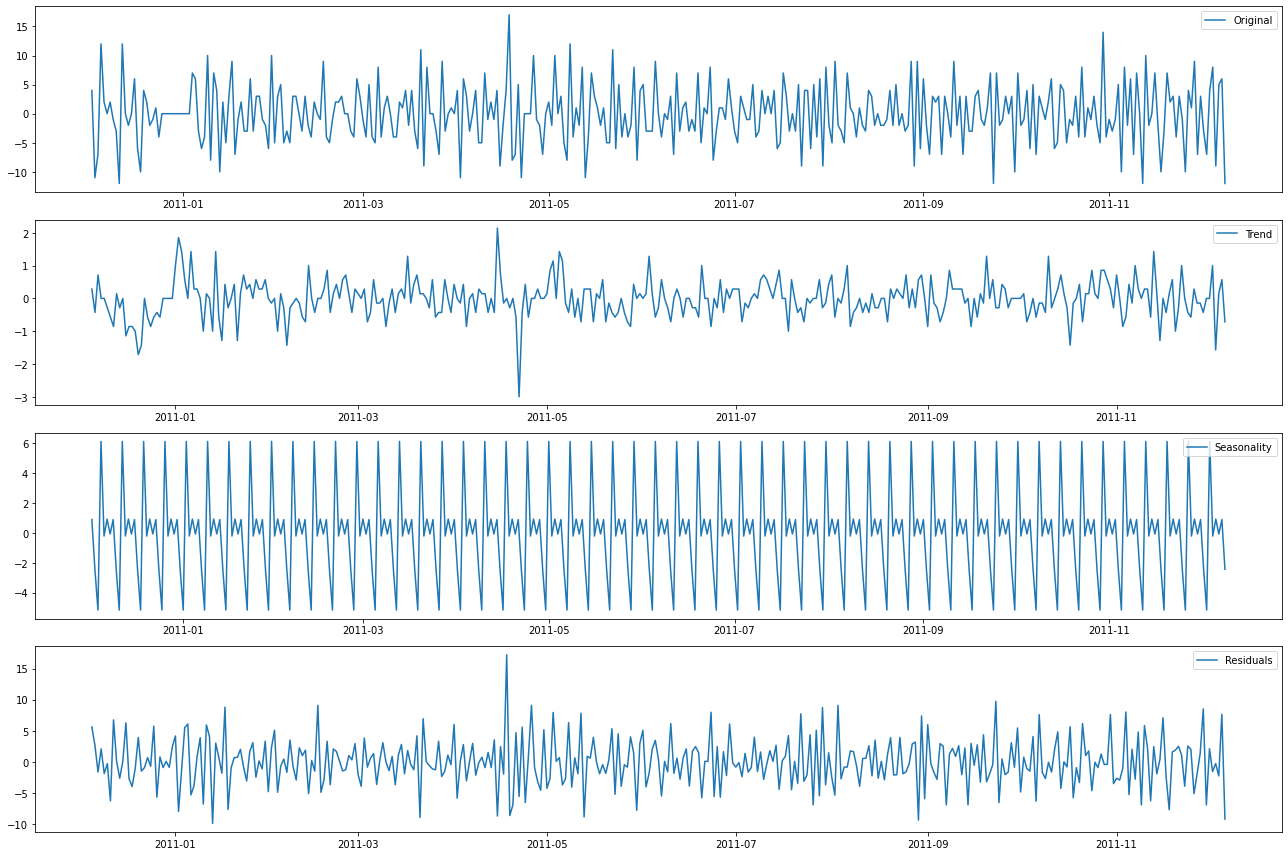

In [200]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_p_prev)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(18,12))
plt.subplot(411)
plt.plot(ts_p_prev, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [201]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [202]:
lag_acf = acf(ts_p_prev, nlags=20)
lag_pacf = pacf(ts_p_prev, nlags=20, method='ols')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



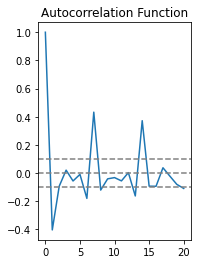

In [203]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_p_prev)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_p_prev)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

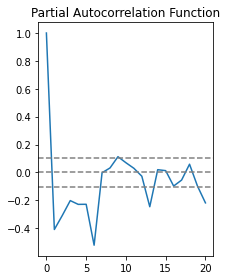

In [204]:
#Plot PACF:
ax1 = plt.subplot(122)
ax1.plot(lag_pacf)
ax1.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_p_prev)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_p_prev)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Text(0.5, 1.0, 'RSS: nan')

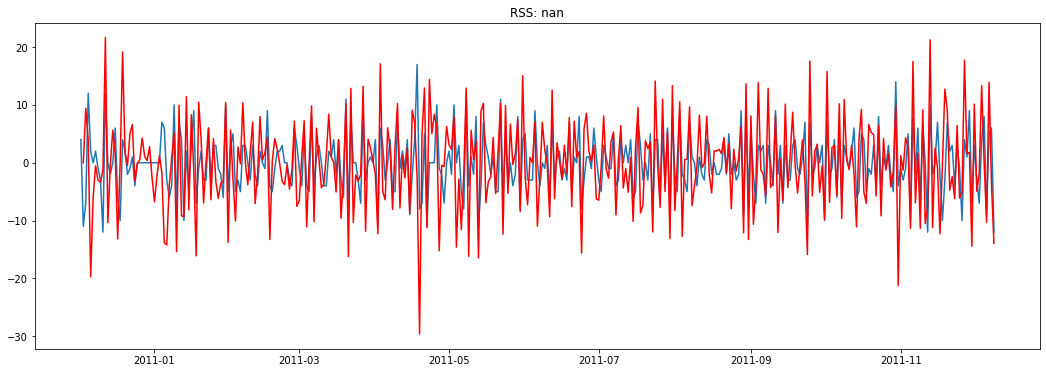

In [205]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_p_prev, order=(7, 1, 7))  
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(18,6))  
plt.plot(ts_p_prev)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_p_prev)**2))

In [206]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

InvoiceDate
2010-12-03     0.000300
2010-12-04     9.410497
2010-12-05     3.960280
2010-12-06   -19.744324
2010-12-07    -6.066700
Freq: D, dtype: float64

In [207]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

InvoiceDate
2010-12-03     0.000300
2010-12-04     9.410797
2010-12-05    13.371077
2010-12-06    -6.373247
2010-12-07   -12.439947
Freq: D, dtype: float64

In [208]:
predictions_ARIMA = pd.Series(df.iloc[:, 0], index=ts_p_prev.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA.head()

InvoiceDate
2010-12-02            NaN
2010-12-03    0.000299561
2010-12-04         9.4108
2010-12-05        13.3711
2010-12-06       -6.37325
Freq: D, dtype: object

In [209]:
predictions_ARIMA.tail()

InvoiceDate
2011-12-05   -59.1521
2011-12-06   -69.4829
2011-12-07     -55.57
2011-12-08   -59.3733
2011-12-09   -73.3223
Freq: D, dtype: object

### FB-Prophet

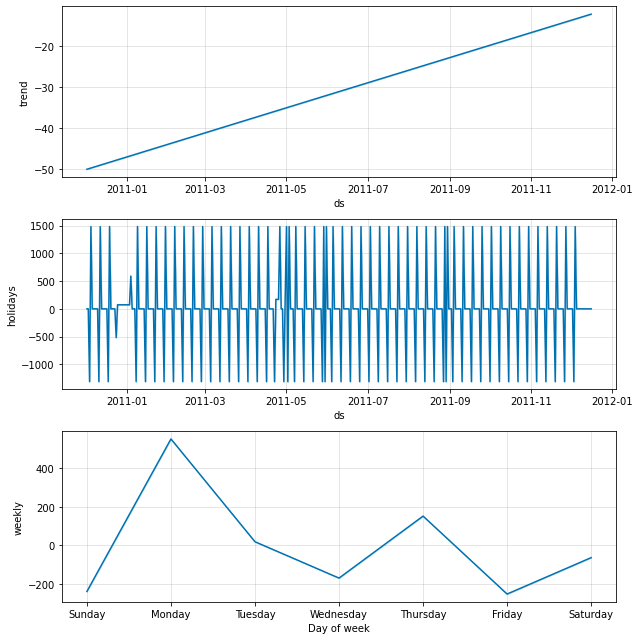

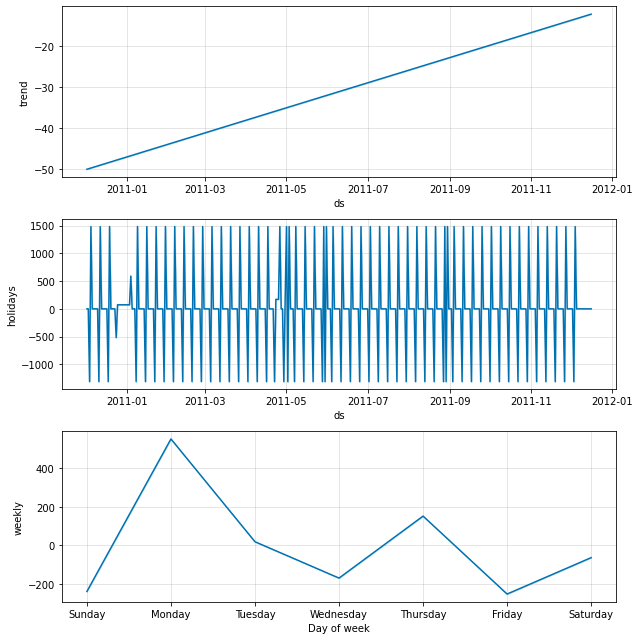

In [210]:
ts_model_d.plot_components(prediction)

In [211]:
ts_p = df_p[['InvoiceDate', 'count']].set_index('InvoiceDate', drop = True)
ts_p = ts_p.resample('D').sum()
ts_p.head()

count
InvoiceDate       
2010-12-01      14
2010-12-02      18
2010-12-03       7
2010-12-04       0
2010-12-05      12

In [212]:
ts_p['prev_count'] = ts_p['count'] - ts_p['count'].shift(1)

In [213]:
ts_p = ts_p.reset_index()
ts_p.head()

InvoiceDate  count  prev_count
0  2010-12-01     14         NaN
1  2010-12-02     18         4.0
2  2010-12-03      7       -11.0
3  2010-12-04      0        -7.0
4  2010-12-05     12        12.0

In [214]:
ts = ts_p[['InvoiceDate','prev_count']][1:]
ts.columns = ['ds', 'y']
ts.head()
ts_model_d = Prophet(holidays = holidays)
ts_model_d.fit(ts)
future = ts_model_d.make_future_dataframe(periods=30, freq = 'D')
prediction = ts_model_d.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


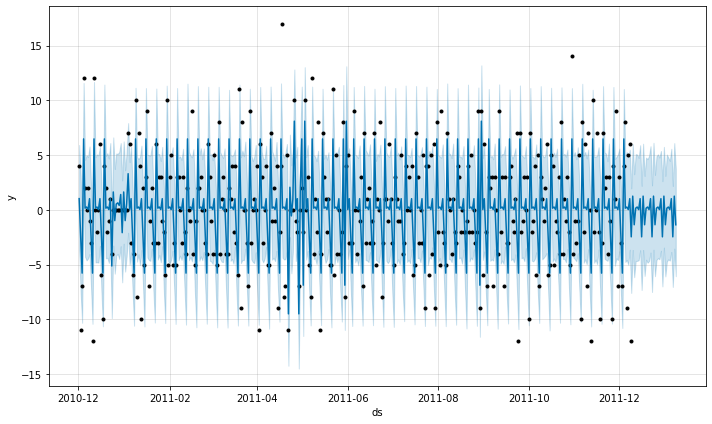

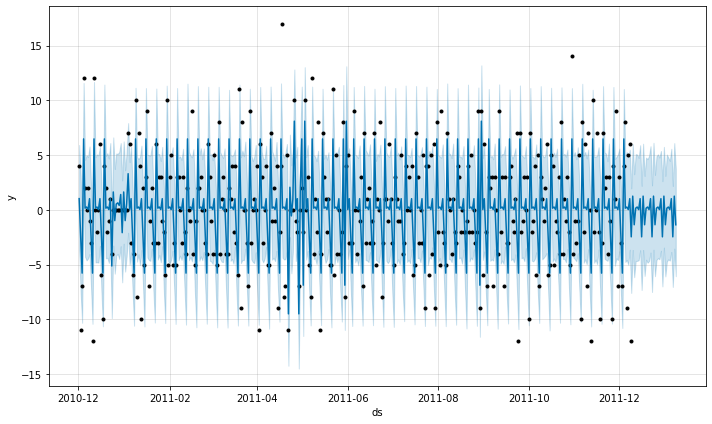

In [215]:
ts_model_d.plot(prediction)

In [216]:
prediction

ds     trend  ...  multiplicative_terms_upper      yhat
0   2010-12-02 -0.161855  ...                         0.0  1.019081
1   2010-12-03 -0.161863  ...                         0.0 -2.467281
2   2010-12-04 -0.161871  ...                         0.0 -5.783402
3   2010-12-05 -0.161878  ...                         0.0  6.475526
4   2010-12-06 -0.161886  ...                         0.0  0.150932
..         ...       ...  ...                         ...       ...
398 2012-01-04 -0.164695  ...                         0.0  0.018884
399 2012-01-05 -0.164703  ...                         0.0  1.016233
400 2012-01-06 -0.164710  ...                         0.0 -2.470128
401 2012-01-07 -0.164717  ...                         0.0  1.248881
402 2012-01-08 -0.164724  ...                         0.0 -1.367928

[403 rows x 25 columns]

In [217]:
ts = ts_p[['InvoiceDate','prev_count']][1:]
ts.columns = ['ds', 'y']
ts.head()
ts_model_d = Prophet(holidays = holidays)
ts_model_d.fit(ts)
future = ts_model_d.make_future_dataframe(periods=30, freq = 'D')
prediction = ts_model_d.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


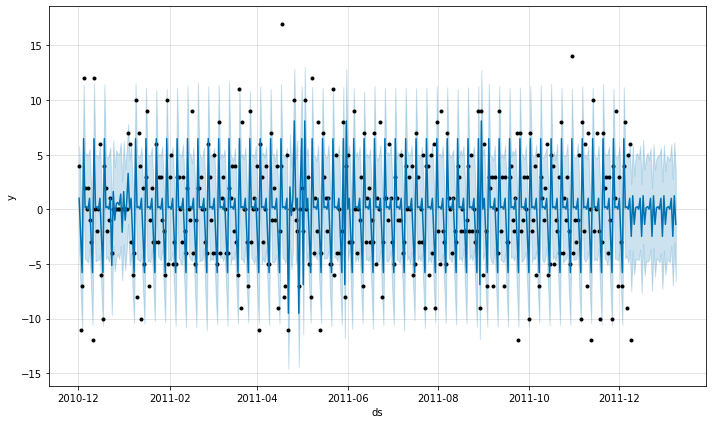

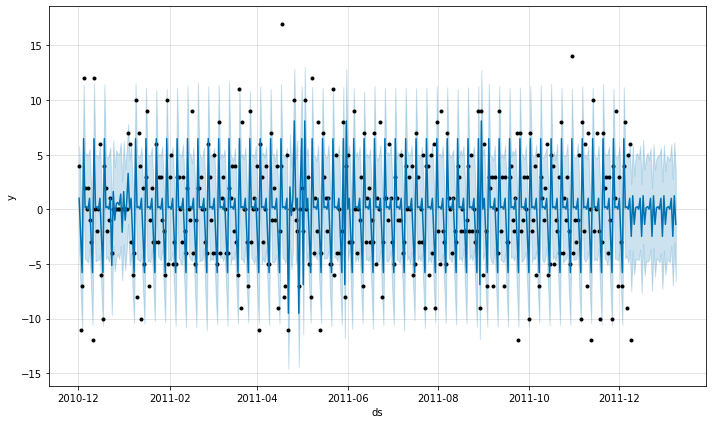

In [218]:
ts_model_d.plot(prediction)

In [219]:
prediction

ds     trend  ...  multiplicative_terms_upper      yhat
0   2010-12-02 -0.161855  ...                         0.0  1.019081
1   2010-12-03 -0.161863  ...                         0.0 -2.467281
2   2010-12-04 -0.161871  ...                         0.0 -5.783402
3   2010-12-05 -0.161878  ...                         0.0  6.475526
4   2010-12-06 -0.161886  ...                         0.0  0.150932
..         ...       ...  ...                         ...       ...
398 2012-01-04 -0.164695  ...                         0.0  0.018884
399 2012-01-05 -0.164703  ...                         0.0  1.016233
400 2012-01-06 -0.164710  ...                         0.0 -2.470128
401 2012-01-07 -0.164717  ...                         0.0  1.248881
402 2012-01-08 -0.164724  ...                         0.0 -1.367928

[403 rows x 25 columns]

In [220]:
ts = ts_p[['InvoiceDate','count']]
ts.columns = ['ds', 'y']
ts.head()
ts_model_d = Prophet(holidays = holidays)
ts_model_d.fit(ts)
future = ts_model_d.make_future_dataframe(periods=0, freq = 'D')
prediction = ts_model_d.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


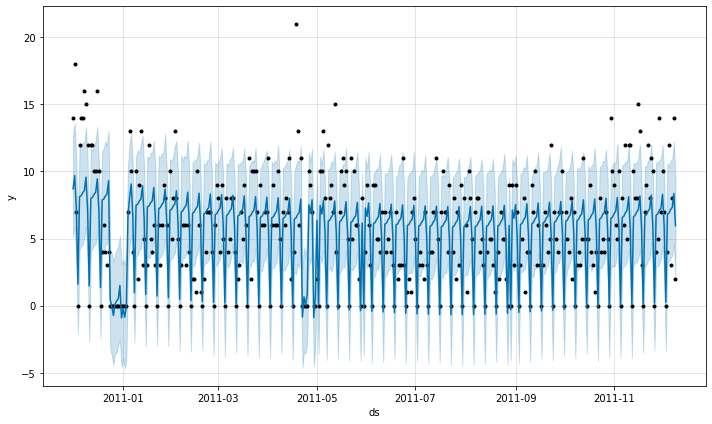

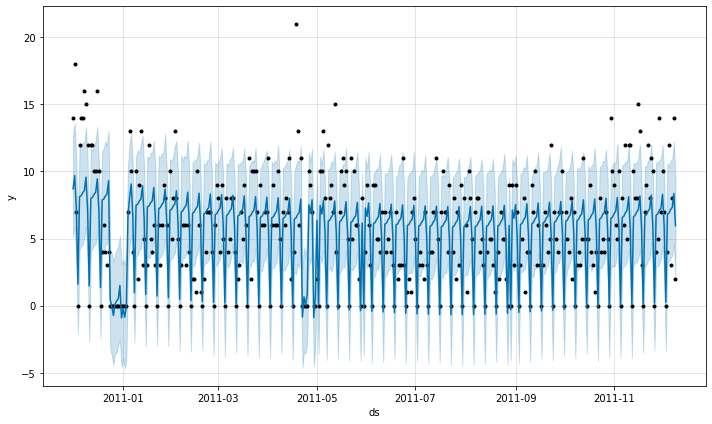

In [221]:
ts_model_d.plot(prediction)

In [222]:
prediction

ds     trend  ...  multiplicative_terms_upper      yhat
0   2010-12-01  8.278308  ...                         0.0  8.696098
1   2010-12-02  8.260213  ...                         0.0  9.690521
2   2010-12-03  8.242117  ...                         0.0  7.272652
3   2010-12-04  8.224022  ...                         0.0  1.598883
4   2010-12-05  8.205927  ...                         0.0  8.117556
..         ...       ...  ...                         ...       ...
369 2011-12-05  6.891187  ...                         0.0  6.889323
370 2011-12-06  6.899547  ...                         0.0  7.151752
371 2011-12-07  6.907907  ...                         0.0  7.325697
372 2011-12-08  6.916266  ...                         0.0  8.346575
373 2011-12-09  6.924626  ...                         0.0  5.955161

[374 rows x 25 columns]

In [223]:
ts_p['prediction_count'] = prediction['yhat']
ts_p.head()

InvoiceDate  count  prev_count  prediction_count
0  2010-12-01     14         NaN          8.696098
1  2010-12-02     18         4.0          9.690521
2  2010-12-03      7       -11.0          7.272652
3  2010-12-04      0        -7.0          1.598883
4  2010-12-05     12        12.0          8.117556

In [224]:
ts_p = ts_p.set_index('InvoiceDate', drop = True)

Text(0.5, 1.0, 'RSS: 3218.1423')

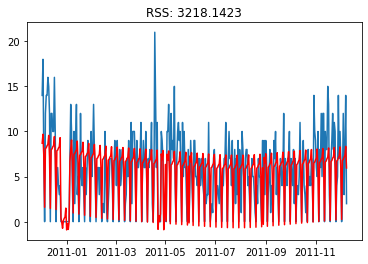

In [225]:
plt.plot(ts_p['count'])
plt.plot(ts_p['prediction_count'], color='red')
plt.title('RSS: %.4f'% sum((ts_p['prediction_count']-ts_p['count'])**2))

### AutoRegressive Model

In [226]:
df_p = products[products['productId'] == '85123A']
print(df_p.head())
print(df_p.isnull().sum())
print(df_p.columns)

  InvoiceNo StockCode  Quantity  ... medianCustomersPerWeek  month  count
0    536365    85123A         6  ...                   38.0     12      1
1    536373    85123A         6  ...                   38.0     12      1
2    536375    85123A         6  ...                   38.0     12      1
3    536394    85123A        32  ...                   38.0     12      1
4    536396    85123A         6  ...                   38.0     12      1

[5 rows x 33 columns]
InvoiceNo                   0
StockCode                   0
Quantity                    0
InvoiceDate                 0
UnitPrice                   0
CustomerID                222
Country                     0
productId                   0
Description                 0
custIdPresent               0
date                        0
maxPurchaseDate             0
recency                     0
recencyCluster              0
frequency                   0
frequencyCluster            0
totalPrice                  0
monetary               

In [227]:
df_p.Country.value_counts()

United Kingdom    2075
Name: Country, dtype: int64

In [228]:
df_p = df_p[df_p.Country == 'United Kingdom']

In [229]:
df_p.shape

(2075, 33)

In [230]:
df_p.isnull().sum()

InvoiceNo                   0
StockCode                   0
Quantity                    0
InvoiceDate                 0
UnitPrice                   0
CustomerID                222
Country                     0
productId                   0
Description                 0
custIdPresent               0
date                        0
maxPurchaseDate             0
recency                     0
recencyCluster              0
frequency                   0
frequencyCluster            0
totalPrice                  0
monetary                    0
monetaryCluster             0
finalScore                  0
segment                     0
yearWeek                    0
weekDay                     0
medianPrice                 0
medianQuantities            0
customers                   0
weeklySale                  0
medianWeekDaySales          0
weeklyCustomers             0
meanCustomersPerWeek        0
medianCustomersPerWeek      0
month                       0
count                       0
dtype: int

In [231]:
# Filling NA values with '-1'
df_p.fillna('-1', inplace = True)

In [232]:
df_p_cust = df_p[['InvoiceDate', 'count']].set_index('InvoiceDate', drop = True)
df_p_cust.head()

count
InvoiceDate               
2010-12-01 08:26:00      1
2010-12-01 09:02:00      1
2010-12-01 09:32:00      1
2010-12-01 10:39:00      1
2010-12-01 10:51:00      1

In [233]:
df_p_cust = df_p_cust.resample('D').sum()
df_p_cust.head()

count
InvoiceDate       
2010-12-01      14
2010-12-02      18
2010-12-03       7
2010-12-04       0
2010-12-05      12

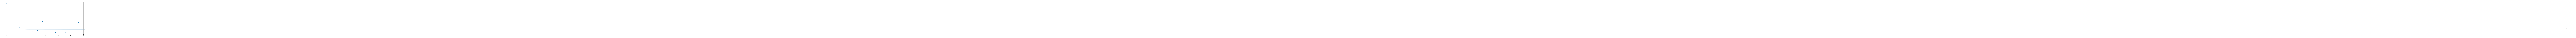

In [234]:
max_lag = 30
fig, ax = plt.subplots(figsize = (18, 7))
acf_plot = plot_acf(x = df_p_cust['count'],
                    ax = ax,
                    lags = max_lag,
                    use_vlines = False,
                    alpha = 0.9,
                    title = 'Autocorrelation of Customer ID per week vs. lag')
ax.grid(True)
ax.text(1000, 0.01, '90% confidence interval')
ax.set_xlabel('Lag', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

- Every 7th day is in correalation with current date

In [235]:
# the statsmodels plot_acf is based upon the numpy correlate
# function, so we can generate the actual values for 
# illustration and so we can label some later plots
# the standard presentation of an acf plot has the value at 
# lag 0 == 1; the correlate function returns unscaled
# values so we get the first value for scaling to 1
# the values to be tested in the function must have
# the mean of the un-shifted series subtracted from 
# both series
max_lag = 16
corr0 = np.correlate(df_p_cust['count'][0: ] - 
                     df_p_cust['count'].mean(), 
                     df_p_cust['count'][0: ] - 
                     df_p_cust['count'].mean(), 
                     mode = 'valid')
corrs = [np.correlate(df_p_cust['count'][:(df_p_cust['count'].shape[0] - i)] - 
                     df_p_cust['count'].mean(), 
                      df_p_cust['count'][i: ] - 
                      df_p_cust['count'].mean(), 
                      mode = 'valid')
        for i in range(max_lag)] / corr0

In [236]:
# utility function to plot out a range of 
# plots depicting self-correlation
def plot_lag_grid(series, corrs, 
                  axis_min, axis_max, 
                  num_plots, total_lag,
                  n_rows, n_cols):
    lag_step = int(total_lag / num_plots)
    fig = plt.figure(figsize = (18, 16))
    for i in range(num_plots):
        corr = corrs[lag_step * i]
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        ax.scatter(series, series.shift(lag_step * i))
        ax.set_xlim(axis_min, axis_max)
        ax.set_ylim(axis_min, axis_max)
        ax.set_title('lag = ' + str(lag_step * i))
        ax.text(axis_min + 0.05 * (axis_max - axis_min),
                axis_max - 0.05 * (axis_max - axis_min),
                'correlation = ' + str(round(corr[0], 3)))
    fig.tight_layout()
    plt.show()

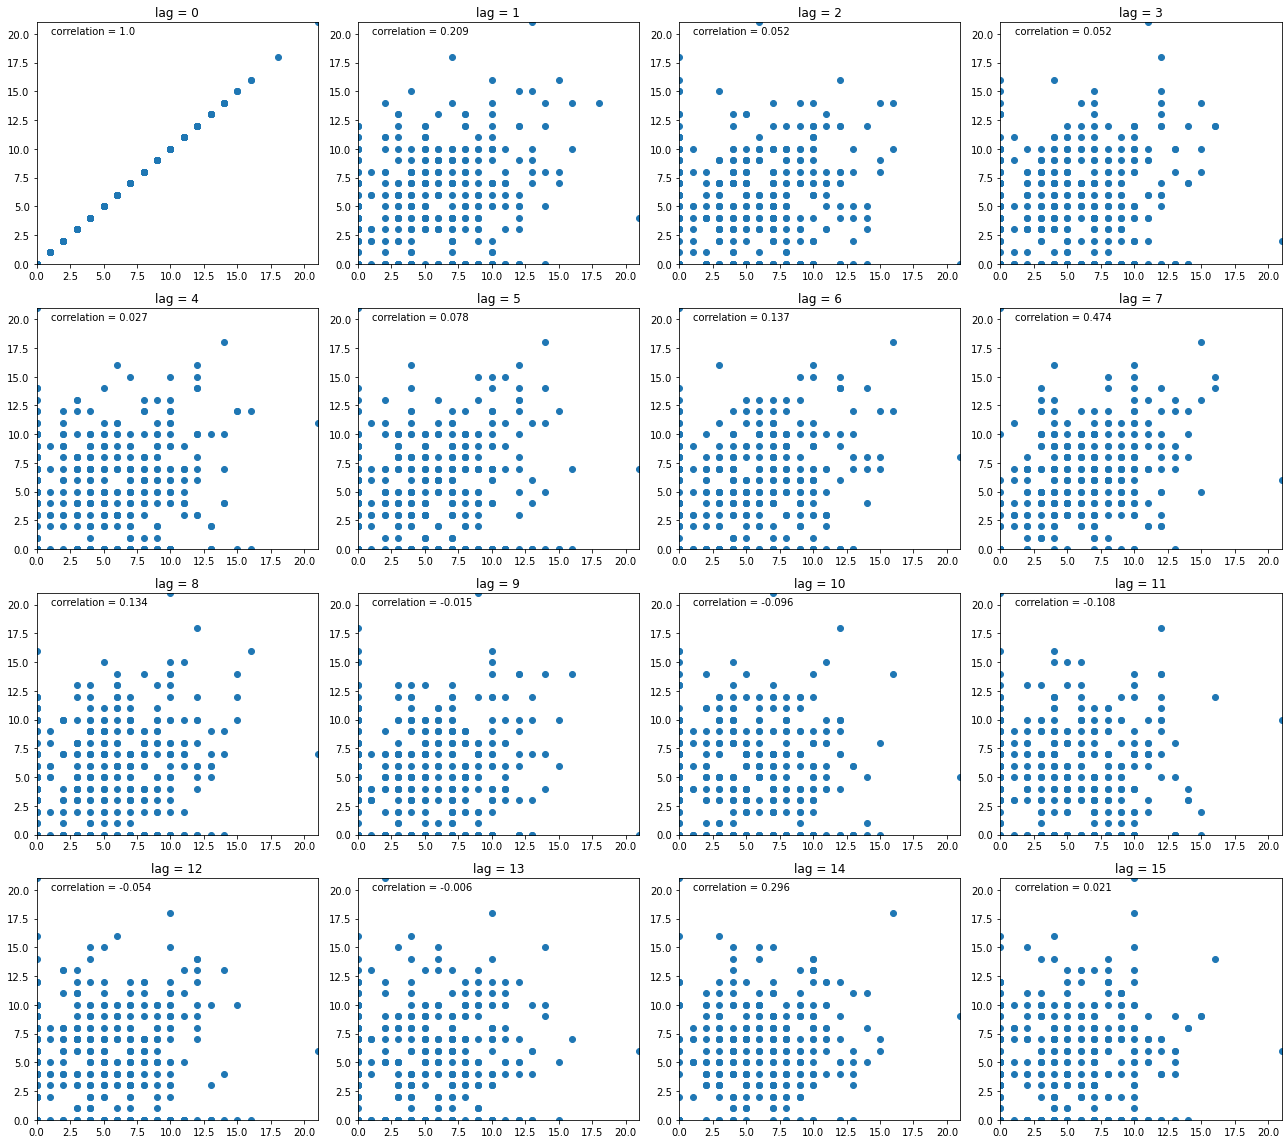

In [237]:
# create a grid to see how well the data at increasing 
# lags correlates to the original data
# 'perfect' correlation will appear as a diagonal line
# the farther from the line, the poorer the correlation
plot_lag_grid(df_p_cust['count'], corrs,
              df_p_cust['count'].min(), df_p_cust['count'].max(),
              num_plots = 16,
              total_lag = 16,
              n_rows = 4, n_cols = 4)

In [238]:
# Shifting the Customer count by 7 days
df_p_cust['countShift7'] = df_p_cust.shift(7)
df_p_cust.head(20)

count  countShift7
InvoiceDate                    
2010-12-01      14          NaN
2010-12-02      18          NaN
2010-12-03       7          NaN
2010-12-04       0          NaN
2010-12-05      12          NaN
2010-12-06      14          NaN
2010-12-07      14          NaN
2010-12-08      16         14.0
2010-12-09      15         18.0
2010-12-10      12          7.0
2010-12-11       0          0.0
2010-12-12      12         12.0
2010-12-13      12         14.0
2010-12-14      10         14.0
2010-12-15      10         16.0
2010-12-16      16         15.0
2010-12-17      10         12.0
2010-12-18       0          0.0
2010-12-19       4         12.0
2010-12-20       6         12.0

In [239]:
# continuing the same procedure for Quantity sold per week
df_q = df_p[['InvoiceDate', 'Quantity']].set_index('InvoiceDate', drop = True)
df_q = df_q.resample('D').sum()
df_q.head()

Quantity
InvoiceDate          
2010-12-01        134
2010-12-02        149
2010-12-03         25
2010-12-04          0
2010-12-05         70

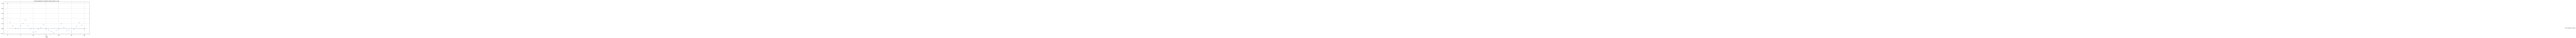

In [240]:
max_lag = 30
fig, ax = plt.subplots(figsize = (18, 7))
acf_plot = plot_acf(x = df_q['Quantity'],
                    ax = ax,
                    lags = max_lag,
                    use_vlines = False,
                    alpha = 0.9,
                    title = 'Autocorrelation of Customer ID per week vs. lag')
ax.grid(True)
ax.text(1000, 0.01, '90% confidence interval')
ax.set_xlabel('Lag', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

- There is some correlation with quantity on 7th day of product sold.

In [241]:
# Shifting the Quantity sold by 7 days
df_q['quantityShift7'] = df_q.shift(7)
df_q.head(20)

Quantity  quantityShift7
InvoiceDate                          
2010-12-01        134             NaN
2010-12-02        149             NaN
2010-12-03         25             NaN
2010-12-04          0             NaN
2010-12-05         70             NaN
2010-12-06        161             NaN
2010-12-07        203             NaN
2010-12-08        151           134.0
2010-12-09        194           149.0
2010-12-10        101            25.0
2010-12-11          0             0.0
2010-12-12         42            70.0
2010-12-13        177           161.0
2010-12-14        121           203.0
2010-12-15        112           151.0
2010-12-16        170           194.0
2010-12-17         52           101.0
2010-12-18          0             0.0
2010-12-19         42            42.0
2010-12-20         85           177.0

In [242]:
df_p_q = df_q.reset_index().merge(df_p_cust.reset_index(), on = 'InvoiceDate')

In [243]:
df_p_q.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 0 to 373
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   InvoiceDate     374 non-null    datetime64[ns]
 1   Quantity        374 non-null    int64         
 2   quantityShift7  367 non-null    float64       
 3   count           374 non-null    int64         
 4   countShift7     367 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 17.5 KB


In [244]:
df_p['date'] = df_p['date'].astype(str)
df_p_q['InvoiceDate'] = df_p_q['InvoiceDate'].astype(str)
df_p = df_p.merge(df_p_q[['InvoiceDate', 'countShift7', 'quantityShift7']], left_on = 'date', right_on='InvoiceDate')
df_p.drop('InvoiceDate_y', axis = 1, inplace = True)
df_p = df_p.rename(columns = {'InvoiceDate_x':'InvoiceDate'})
df_p.dropna(axis = 0, inplace = True)
df_p.head()

InvoiceNo StockCode  Quantity  ... count  countShift7 quantityShift7
51    537669    85123A        12  ...     1         14.0          134.0
52    537674    85123A         6  ...     1         14.0          134.0
53    537754    85123A         3  ...     1         14.0          134.0
54    537755    85123A        32  ...     1         14.0          134.0
55    537764    85123A         1  ...     1         14.0          134.0

[5 rows x 35 columns]

In [245]:
df_p.shape

(1996, 35)

In [246]:
a = df_p.groupby('date', as_index = False)['Quantity'].sum().rename(columns= {'Quantity':'dailyQuantity'})
df_p = df_p.merge(a, on = 'date')
df_p.head()

InvoiceNo StockCode  Quantity  ... countShift7  quantityShift7 dailyQuantity
0    537669    85123A        12  ...        14.0           134.0           151
1    537674    85123A         6  ...        14.0           134.0           151
2    537754    85123A         3  ...        14.0           134.0           151
3    537755    85123A        32  ...        14.0           134.0           151
4    537764    85123A         1  ...        14.0           134.0           151

[5 rows x 36 columns]

### Predition using engineered features

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



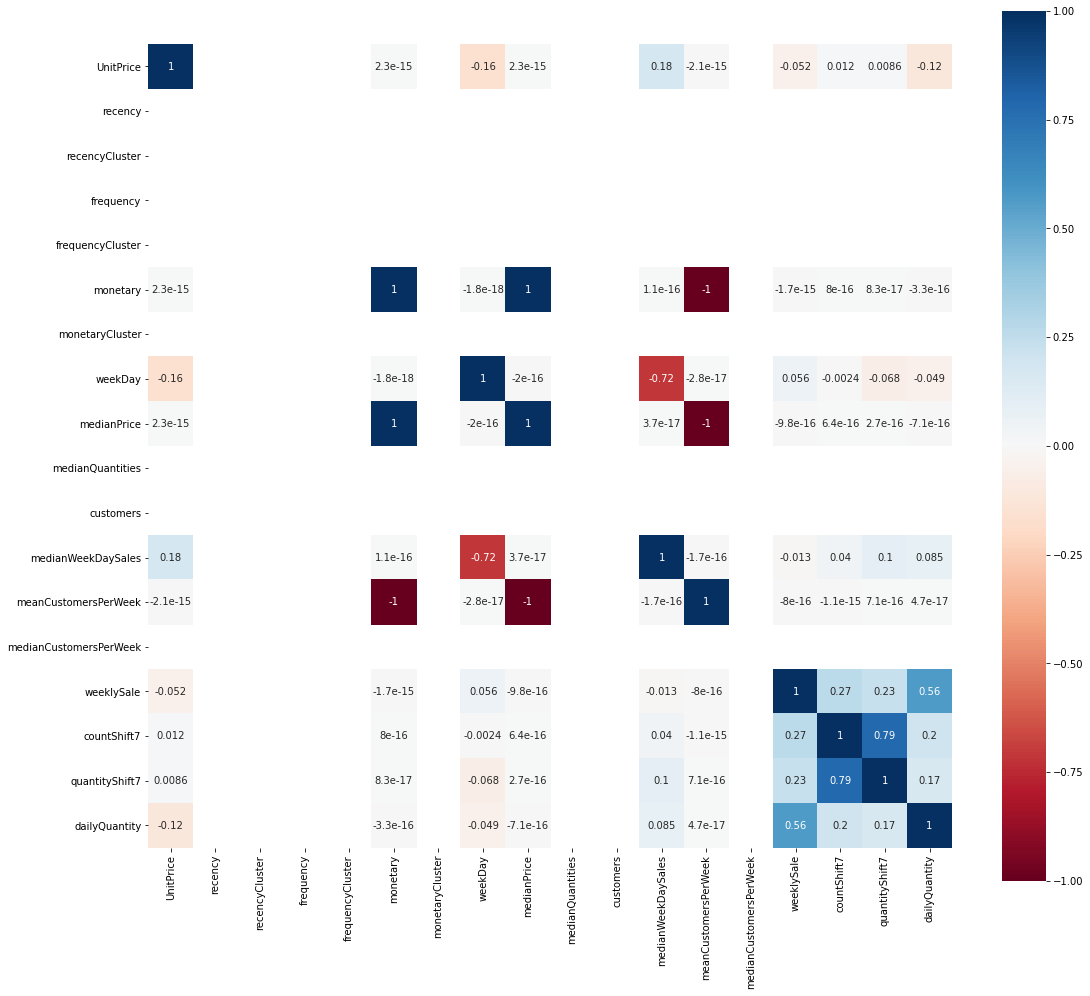

In [247]:
predictionColumns = ['UnitPrice', 'recency', 'recencyCluster', 'frequency',
                      'frequencyCluster', 'monetary', 'monetaryCluster', 
                      'weekDay', 'medianPrice', 'medianQuantities', 
                      'customers', 'medianWeekDaySales','meanCustomersPerWeek', 
                     'medianCustomersPerWeek', 'weeklySale', 'countShift7', 
                     'quantityShift7', 'dailyQuantity']
corr_df = df_p[predictionColumns]
corr_df.drop_duplicates(inplace=True)
plt.figure(figsize = (18,16))
sns.heatmap(corr_df.corr(), square=True, annot=True, cmap="RdBu", vmin=-1, vmax=1)
plt.show()

In [248]:
predictionColumns = ['UnitPrice', 'recency', 'recencyCluster', 'frequency',
                      'frequencyCluster', 'monetary', 'monetaryCluster', 
                      'weekDay', 'medianPrice', 'medianQuantities', 
                      'customers', 'medianWeekDaySales','meanCustomersPerWeek', 
                     'medianCustomersPerWeek', 'countShift7', 
                     'quantityShift7', 'dailyQuantity']

data = df_p[predictionColumns]
data = data.drop_duplicates().reset_index(drop=True)

X = data.drop('dailyQuantity', axis = 1)
y = data['dailyQuantity']

dummy_data = create_dummy_variables(X[['monetaryCluster','frequencyCluster','recencyCluster', 'weekDay']])
print(dummy_data.head())

X.drop(['recencyCluster', 'frequencyCluster', 'monetaryCluster', 'weekDay'], axis = 1, inplace = True)

X = pd.concat([X,dummy_data], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('R-squared score {}'.format(r2_score(y_test, y_pred)))

   weekDay_1  weekDay_2  weekDay_3  weekDay_4  weekDay_6
0          0          1          0          0          0
1          0          1          0          0          0
2          0          1          0          0          0
3          0          0          1          0          0
4          0          0          1          0          0
R-squared score 0.16323457638455152


In [275]:
a = products.groupby(['productId', 'yearWeek']).agg({
    'Quantity':'sum',
    'count' : 'sum'
})
a = a.reset_index()
a.columns = ['productId', 'yearWeek', 'weeklyQuantity', 'weeklyCustomer']
a = a.sort_values('yearWeek')
unique_products = a.productId.unique()


df_out = pd.DataFrame(columns=['productId',	'yearWeek',	'weeklyQuantity', 'weeklyCustomer',  'weeklyQuantityShifted', 'weeklyCustomerShifted'])
for p in unique_products:
  b = a[a.productId == p]
  b['weeklyQuantityShifted'] = b['weeklyQuantity'].shift(1)
  b['weeklyCustomerShifted'] = b['weeklyCustomer'].shift(1)
  df_out = df_out.append(b)

df_out.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(98317, 6)

In [282]:
products = products.merge(df_out, on = ['productId', 'yearWeek'])

In [284]:
products = products.fillna({'CustomerID':'-1'}).dropna(axis = 0)

In [286]:
products.dropna(axis = 0, inplace = True)

In [287]:
products.shape

(461026, 37)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



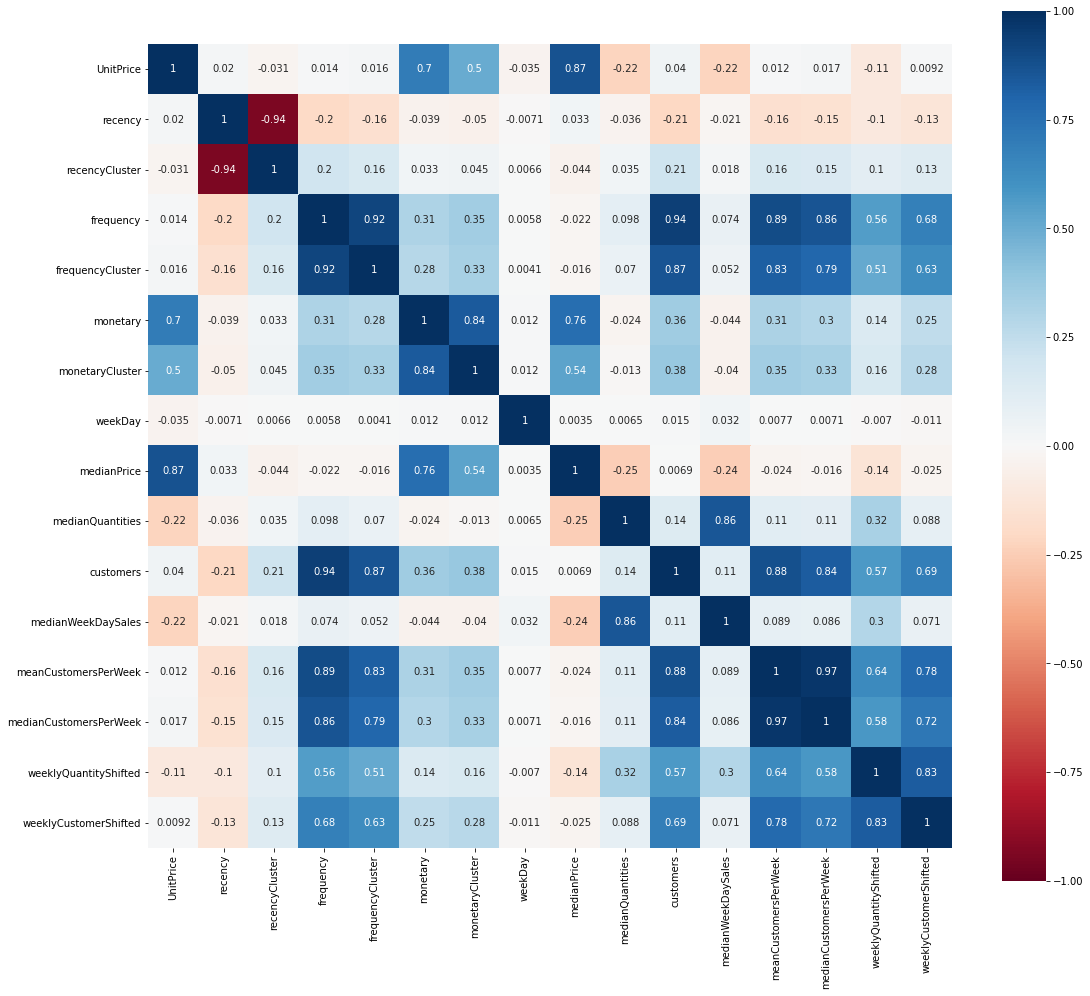

In [288]:
predictionColumns = ['UnitPrice', 'recency', 'recencyCluster', 'frequency',
                      'frequencyCluster', 'monetary', 'monetaryCluster', 
                      'weekDay', 'medianPrice', 'medianQuantities', 
                      'customers', 'medianWeekDaySales','meanCustomersPerWeek', 
                     'medianCustomersPerWeek', 'weeklyQuantityShifted', 'weeklyCustomerShifted',
                     'weeklyQuantity']
corr_df = products[predictionColumns]
corr_df.drop_duplicates(inplace=True)
plt.figure(figsize = (18,16))
sns.heatmap(corr_df.corr(), square=True, annot=True, cmap="RdBu", vmin=-1, vmax=1)
plt.show()

In [289]:
predictionColumns = ['UnitPrice', 'recency', 'recencyCluster', 'frequency',
                      'frequencyCluster', 'monetary', 'monetaryCluster', 
                      'weekDay', 'medianPrice', 'medianQuantities', 
                      'customers', 'medianWeekDaySales','meanCustomersPerWeek', 
                     'medianCustomersPerWeek', 'weeklyQuantityShifted', 'weeklyCustomerShifted',
                     'weeklyQuantity']

data = products[predictionColumns]
data = data.drop_duplicates().reset_index(drop=True)

X = data.drop('weeklyQuantity', axis = 1)
y = data['weeklyQuantity']

dummy_data = create_dummy_variables(X[['monetaryCluster','frequencyCluster','recencyCluster', 'weekDay']])
X.drop(['recencyCluster', 'frequencyCluster', 'monetaryCluster', 'weekDay'], axis = 1, inplace = True)
X = pd.concat([X,dummy_data], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('R-squared score {}'.format(r2_score(y_test, y_pred)))

R-squared score 0.5542840634464477


In [255]:
from sklearn.model_selection import KFold

predictionColumns = ['UnitPrice', 'recency', 'recencyCluster', 'frequency',
                      'frequencyCluster', 'monetary', 'monetaryCluster', 
                      'weekDay', 'medianPrice', 'medianQuantities', 
                      'customers', 'medianWeekDaySales','meanCustomersPerWeek', 
                     'medianCustomersPerWeek', 'weeklyQuantityShifted', 'weeklyCustomerShifted',
                     'weeklyQuantity']

data = products[predictionColumns]
data = data.drop_duplicates().reset_index(drop=True)

X = data.drop('weeklyQuantity', axis = 1)
y = data[['weeklyQuantity']]

kf = KFold(n_splits=10, shuffle = False)
kf.get_n_splits(X)
print(kf)
r2_scores = {}
i = 1

for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
  y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

  rf = RandomForestRegressor()
  rf.fit(X_train, y_train.values.ravel())
  y_pred = rf.predict(X_test)

  r2_scores[i] = r2_score(y_test, y_pred)
  print('R-squared score at i = {} is {}'.format(i, r2_scores[i]))

  i += 1

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



KFold(n_splits=10, random_state=0, shuffle=False)
R-squared score at i = 1 is 0.5967849328250747
R-squared score at i = 2 is 0.534023014611525
R-squared score at i = 3 is 0.6403726469848976
R-squared score at i = 4 is 0.5497525079552614
R-squared score at i = 5 is 0.45165386419891285
R-squared score at i = 6 is 0.5468378283499888
R-squared score at i = 7 is 0.4839513491938231
R-squared score at i = 8 is 0.42781989050583
R-squared score at i = 9 is 0.47415456987679194
R-squared score at i = 10 is 0.6248432213162362


In [256]:
np.mean(list(r2_scores.values()))

0.533019382581834

In [257]:
np.std(list(r2_scores.values()))

0.06932125152602012

In [290]:
predictionColumns = ['UnitPrice', 'recency', 'recencyCluster', 'frequency',
                      'frequencyCluster', 'monetary', 'monetaryCluster', 
                      'weekDay', 'medianPrice', 'medianQuantities', 
                      'customers', 'medianWeekDaySales','meanCustomersPerWeek', 
                     'medianCustomersPerWeek', 'weeklyQuantityShifted', 'weeklyCustomerShifted',
                     'weeklyQuantity']

data = products[predictionColumns]
data = data.drop_duplicates().reset_index(drop=True)

X = data.drop('weeklyQuantity', axis = 1)
y = data['weeklyQuantity']

dummy_data = create_dummy_variables(X[['monetaryCluster','frequencyCluster','recencyCluster', 'weekDay']])
X.drop(['recencyCluster', 'frequencyCluster', 'monetaryCluster', 'weekDay'], axis = 1, inplace = True)
X = pd.concat([X,dummy_data], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle = False)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_val = rf.predict(X_val)

print('R-squared score {}'.format(r2_score(y_val, y_pred_val)))

y_pred = rf.predict(X_test)

print('R-squared score {}'.format(r2_score(y_test, y_pred)))

R-squared score 0.4631255465078471
R-squared score 0.6061469453527949


### Changing train_test split

In [291]:
train_data = products[products['yearWeek'] != 201149]
train_data = train_data[predictionColumns]
train_data = train_data.drop_duplicates()

test_data = products[products['yearWeek'] == 201149]
test_data = test_data[predictionColumns]
test_data = test_data.drop_duplicates()

train_data.shape, test_data.shape

((289027, 17), (9172, 17))

In [292]:
X_train, y_train = train_data.iloc[:,:-1], train_data[['weeklyQuantity']]
X_train.shape

(289027, 16)

In [293]:
X_test, y_test = test_data.iloc[:,:-1], test_data[['weeklyQuantity']]
X_test.shape

(9172, 16)

In [294]:
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
  X_test[col] = 0

In [295]:
X_test.shape

(9172, 16)

In [296]:
X_train = X_train.loc[:, X_train.columns != 'productId']
X_test = X_test.loc[:, X_test.columns != 'productId']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

dummy_data = create_dummy_variables(X_train[['monetaryCluster','frequencyCluster','recencyCluster', 'weekDay']])
print(dummy_data.head())
X_train.drop(['recencyCluster', 'frequencyCluster', 'monetaryCluster', 'weekDay'], axis = 1, inplace = True)
X_train = pd.concat([X_train,dummy_data], axis = 1)

dummy_data = create_dummy_variables(X_test[['monetaryCluster','frequencyCluster','recencyCluster', 'weekDay']])
print(dummy_data.head())
X_test.drop(['recencyCluster', 'frequencyCluster', 'monetaryCluster', 'weekDay'], axis = 1, inplace = True)
X_test = pd.concat([X_test,dummy_data], axis = 1)

X_train.shape, X_test.shape

    monetaryCluster_1  monetaryCluster_2  ...  weekDay_4  weekDay_6
51                  0                  1  ...          0          0
54                  0                  1  ...          0          0
60                  0                  1  ...          0          0
67                  0                  1  ...          0          0
71                  0                  1  ...          0          0

[5 rows x 14 columns]
      monetaryCluster_1  monetaryCluster_2  ...  weekDay_3  weekDay_4
2036                  0                  1  ...          0          0
2039                  0                  1  ...          0          0
2044                  0                  1  ...          1          0
2046                  0                  1  ...          1          0
2054                  0                  1  ...          1          0

[5 rows x 10 columns]


((289027, 26), (9172, 22))

In [297]:
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
  X_test[col] = 0

In [298]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('R-squared score {}'.format(r2_score(y_test, y_pred)))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



R-squared score 0.6428942980832315
